In [1]:
import warnings
import numpy as np
import sympy as sy
from timeit import timeit
import matplotlib.cm as cm
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
from collections import defaultdict
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')  
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 30

The **fourth-order Runge-Kutta** algorithm, **$\textbf{RK4}$**, has proven to be robust and capable of industrial strength work.                                 
The algorithm is based upon the formal integral of the differential equation:                                                          
$\qquad\begin{align} \frac{dx}{dt} &= f(t, x) \\  x(t) &= \int f(t, x) \ dt \\  x_{n+1} &= x_n + \int^{t_{n+1}}_{t_n} f(t, x) \ dt  \end{align}$

The critical idea here is to expand the integrand around the midpoint of the integration interval and thereby obtain  
$O(h^4)$ precision via the cancellation of the $h$ and $h^3$ terms .                                        
The price paid for the improved precision is having to approximate three derivatives and the unknown $x$ at the middle of the interval.


We will always use the **4th order Runge-Kutta method**, which in vector form is

$\quad\displaystyle\begin{equation} \mathbf{x}_{n+1} = \mathbf{x}_n + \frac{\mathbf{k}_1 + 2\mathbf{k}_2 + 2\mathbf{k}_3 + \mathbf{k}_4}{6} \end{equation}$

where                                                                                                                               
$\qquad\begin{align} \mathbf{k}_1 &=  \mathbf{f}(\mathbf{t}_n,\mathbf{x}_n) \ \mathrm{dt}  \\                              \mathbf{k}_2 &= \mathbf{f}\big(\mathbf{t}_n + \frac{\mathrm{dt}}{2},\mathbf{x}_n + \frac{\mathbf{k}_1}{2}\big) \ \mathrm{dt} \\ \mathbf{k}_3 &= \mathbf{f}\big(\mathbf{t}_n + \frac{\mathrm{dt}}{2},\mathbf{x}_n + \frac{\mathbf{k}_2}{2}\big) \  \mathrm{dt}  \\ \mathbf{k}_4 &= \mathbf{f}\big(\mathbf{t}_n + \mathrm{dt},\mathbf{x}_n + \mathbf{k}_3\big) \  \mathrm{dt}  \end{align}$

In [2]:
def RK4(f, t_span, const, dt, x0):
    time   = np.arange(t_span[0], t_span[1], dt)
    x_n    = np.zeros((len(time), len(x0)), dtype=float)
    x_n[0] = x0
    
    for i in range(len(time)-1):
        k1 = dt * np.array(f(time[i]         , x_n[i]         , const))
        k2 = dt * np.array(f(time[i] + 0.5*dt, x_n[i] + 0.5*k1, const))
        k3 = dt * np.array(f(time[i] + 0.5*dt, x_n[i] + 0.5*k2, const))
        k4 = dt * np.array(f(time[i] +     dt, x_n[i] +     k3, const))
        x_n[i+1] = x_n[i] + (k1 + 2*k2 + 2*k3 + k4) / 6
    return time, x_n

### $\text{Damped Driven Pendulum's Oscillation Equation}$                                                                                                      
The equation of motion is just $I\ddot{\theta} = \Gamma$, where $I$ is the moment of inertia and $\Gamma$ is the net torque about the pivot.                                                                                                                     
In this case $I = m L^2 ,$ and the torque arises from the three forces shown in Figure .    
<img src="https://raw.githubusercontent.com/Chaks1603/Storage/main/Driven-damped-pendulum.png" alt="Driven-damped-pendulum" style="float: right; width: 250px;"/>The resistive force has magnitude $bv$ and hence exerts a torque $-Lbv = -bL^2\dot{\theta}$.                                    
The torque of the weight is $-mgL\sin\theta,$ and that of the driving force is $LF(t)$.                                             
Thus the equation of motion $I\ddot{\theta}=\Gamma$ is                                                                                   
$\quad\begin{align} mL^2\ddot{\theta}=-bL^2\dot{\theta}-mgL\sin\theta+LF(t) \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\quad \ \ \ (1) \end{align}$                                                                          
Let us assume that the driving force $F(t)$ is sinusoidal;                                                                  
$\quad\begin{align} {i.e.}, \qquad F(t)=F_o\cos(\omega t)  \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\quad \ (2)  \end{align}$                                                                    
where $F_o$ is the drive amplitude (the amplitude of the driving force) and $\omega$ the drive frequency.                         
Substituting $(2)$ in $(1)$, we find that,                                                                                                                   
$\quad\begin{align} &{\therefore}\quad mL^2\ddot{\theta}=-bL^2\dot{\theta}-mgL\sin\theta+LF_o\cos(\omega t)  \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad \ (3) \\ 
&{or}, \quad\ddot{\theta} + \underbrace{\frac{b}{m}}_{\equiv \ 2\beta} \dot{\theta} + \underbrace{\frac{g}{L}}_{\equiv \ \omega_o^2} \sin\theta = \underbrace{\frac{F_o}{mL}}_{\equiv \ \gamma\omega_o^2} \cos\omega t \qquad \bigg[\because \gamma=\frac{F_o}{mL\omega_o^2}=\frac{F_o}{mg} \bigg] \\
&{or}, \quad\ddot{\theta}+2\beta\dot{\theta}+\omega^2_o\sin{\theta} = \gamma\omega^2_o\cos\omega t   \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\quad \ \ (4) \\
&{\text{where },}\quad \text{ damping constant }=\beta,  \text{ natural frequency }=\omega_o, \text{ driving strength }=\gamma \ (\text{dimensionless}) \end{align}$

In [3]:
def damped_driven_pendulum(t, y, params):
    theta, theta_dot = y
    beta, omega_o, gamma, omega = params
    dtheta_dt   = theta_dot
    ddtheta_ddt = -2 * beta * theta_dot - omega_o**2 * np.sin(theta) + gamma * omega_o**2 * np.cos(omega * t)
    return [dtheta_dt, ddtheta_ddt]

**12.5** Use Euler's relation and the corresponding expression for $\cos\phi$ (inside the front cover) to prove the identity (12.15).             
   $\qquad\begin{align} \cos^3 x &= \frac{1}{4} (\cos{3x} + 3\cos{x})\end{align}$                                                     
   
From Euler's relation;                                                                                                                            
$\qquad\begin{align} \cos x &= \frac{1}{2}\bigg( e^{ix} + e^{-ix} \bigg) \end{align}$                                              
Cubing on both sides we get :                                                                                                    
$\qquad\begin{align} \cos^3 x &= \bigg(\frac{1}{2}( e^{ix} + e^{-ix}) \bigg)^3 \\ 
&= \frac{1}{8}\bigg( e^{ix} + e^{-ix} \bigg)^3 \\ &= \frac{1}{8}\bigg( e^{3ix} + e^{-3ix} + 3\cdot e^{ix} \cdot e^{-ix}\cdot( e^{ix} + e^{-ix})\bigg) \qquad \big[ (a+b)^3 = a^3+b^3+3\cdot a\cdot b\cdot(a+b)\big] \\ &= \frac{1}{8}\bigg( (e^{3ix} + e^{-3ix}) + 3( e^{ix} + e^{-ix})\bigg) \\ &= \frac{1}{4}\bigg( \frac{1}{2}(e^{3ix} + e^{-3ix}) + \frac{3}{2}( e^{ix} + e^{-ix})\bigg) \\ &= \frac{1}{4} (\cos{3x} + 3\cos{x})\end{align}$ 

**12.6**                                                                                                                                 
(a) Use appropriate sofware to solve the equation (12.11) numerically, for a DDP with the following parameters:              
$ \ \ \ \ $ drive strength $\gamma = 0.9,$ drive frequency $\omega = 2\pi ,$ natural frequency $\omega_o = 1.5\omega ,$ damping constant $\displaystyle\beta=\frac{\omega_o}{4},$ and initial conditions $\phi(0)=\dot{\phi}(0)=0$.                                         
$ \ \ \ \ $ Solve the equation and plot your solution for six cycles $, 0\le t\le 6,$ and verify that you get the result shown in Figure 12.3.                                                                                                                     
(b) and (c) Solve the same equation twice more with the two different initial conditions $\displaystyle\phi(0) = \pm \frac{\pi}{2}$ both with $\dot{\phi}(0) = 0 $                                                                                                     
$ \ \ \ \ $ and plot all three solutions on the same picture.                                                   
$ \ \ \ \ $ Do your results bear out the claim that, for this drive strength, all solutions (whatever their initial conditions) approach the same periodic attractor?

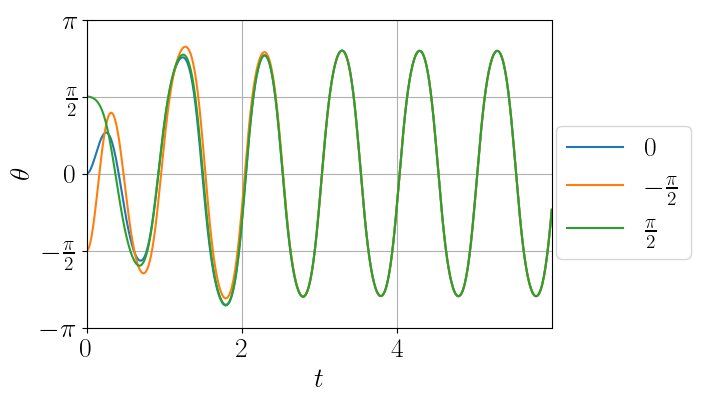

In [4]:
theta0     = [0.0, -np.pi/2, np.pi/2]  # initial angle
theta_dot0 = 0.0                       # initial angular velocity
t_span     = [0, 6]
dt         = 0.01
gamma      = 0.9
omega      = 2*np.pi
omega_o    = 1.5*omega
beta       = omega_o/4
params     = beta, omega_o, gamma, omega 

fig, ax = plt.subplots( figsize=(6,4))
for i, theta0 in enumerate(theta0):
    x0 = [theta0, theta_dot0]
    t, sol = RK4(damped_driven_pendulum, t_span, params, dt, x0)
    theta, theta_dot = sol[:,0], sol[:,1]
    ax.plot(t, theta)
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$\theta$')
    ax.set_xlim([t.min(),t.max()])
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
              [r'$-\pi$', r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$'])
ax.legend([r'$0$',r'$-\frac{\pi}{2}$',r'$\frac{\pi}{2}$'], bbox_to_anchor=(0.98, 0.7), fontsize=20)
ax.grid()
plt.show()

**12.7** Do all the same calculations as in Problem 12.6 but with a drive strength $\gamma = 1.06$ and for $0\le t\le 10.$            
$ \qquad $In part (a) verify that your results agree with Figure 12.4.                                                                  
$ \qquad $Do your results suggest that there is still a unique attractor to which all solutions (whatever their initial conditions) converge?                                                                                                                         
$ \qquad $(At first sight the answer may appear to be "No," but remember that values of 0 that differ by $2\pi$ should be considered to be the same.)

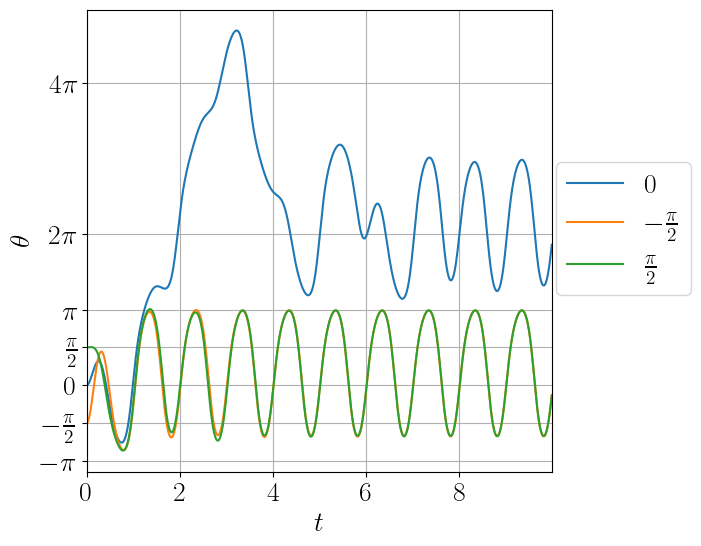

In [5]:
theta0     = [0.0, -np.pi/2, np.pi/2]  # initial angle
theta_dot0 = 0.0                   # initial angular velocity
t_span     = [0, 10]
dt         = 0.01
gamma      = 1.06
omega      = 2*np.pi
omega_o    = 1.5*omega
beta       = omega_o/4
params     = beta, omega_o, gamma, omega 

fig, ax = plt.subplots( figsize=(6,6))
for i, theta0 in enumerate(theta0):
    x0 = [theta0, theta_dot0]
    t, sol = RK4(damped_driven_pendulum, t_span, params, dt, x0)
    theta, theta_dot = sol[:,0], sol[:,1]
    ax.plot(t, theta)
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$\theta$')
    ax.set_xlim([t.min(),t.max()])    
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi, 2*np.pi, 4*np.pi], 
              [r'$-\pi$', r'$-\frac{\pi}{2}$',r'$0$',r'$\frac{\pi}{2}$',r'$\pi$',r'$2\pi$',r'$4\pi$'])
ax.legend([r'$0$',r'$-\frac{\pi}{2}$',r'$\frac{\pi}{2}$'], bbox_to_anchor=(0.98, 0.7), fontsize=20)
ax.grid()
plt.show()

**12.8** Use a computer to find a numerical solution of the equation of motion (12.11) for a DDP with the following parameters :                                                                                                                               
 $ \qquad $drive strength $\gamma = 1.073,$                                                                                                                  
 $ \qquad $drive frequency $\omega=2\pi$,                                                                                                                       
 $ \qquad $natural frequency $\omega_o = 1.5\omega,$                                                                                                           
 $ \qquad $damping constant $\displaystyle\beta=\frac{\omega_o}{4},  $                                                                                   
 $ \qquad $initial conditions $\displaystyle{\phi(0) = \frac{\pi}{2} \ \& \ \dot{\phi}(0) = 0.}$                                                                                                     
 $ \qquad $(a) Solve for $0 \le t \le 50,$ and then plot the first ten cycles$, 0 \le t \le 10.$                                                                                                                  
 $ \qquad $(b) To be sure that the initial transients have died out, plot the ten cycles $40 \le t \le 50.$ What is the period of the long-term motion (the attractor)?

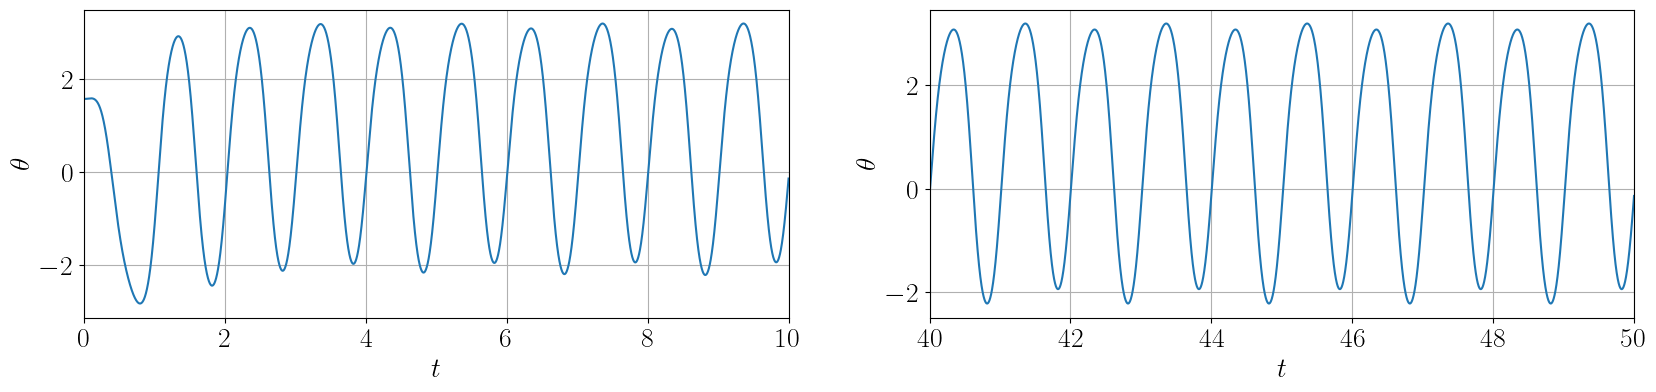

In [6]:
theta0      = np.pi/2                   # initial angle
theta_dot0  = 0.0                   # initial angular velocity
t_span      = [0, 50]
dt          = 0.001
gamma       = 1.073
omega       = 2*np.pi
omega_o     = 1.5*omega
beta        = omega_o/4
params      = beta, omega_o, gamma, omega 
x0          = [theta0, theta_dot0]
t,sol       = RK4(damped_driven_pendulum, t_span, params, dt, x0)
tht,tht_dot = sol[:,0], sol[:,1]

fig, ax = plt.subplots(1,2, figsize=(20,4))
ax[0].plot(t[:int(10/dt)], tht[:int(10/dt)])
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$\theta$')
ax[0].set_xlim([0,10])
ax[0].grid(True)
ax[1].plot(t[int(40/dt):], tht[int(40/dt):])
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$\theta$')
ax[1].set_xlim([40,50])
ax[1].grid(True)
plt.show()

**12.9** Do the same calculations as in Problem 12.8 with all the same parameters except that $\phi(0) = 0.$                              
$ \qquad $Plot the first $30$ cycles $0 \le t \le 30$ and check that you agree with Figure 12.5.                                           
$ \qquad $Plot the ten cycles $40 \le t \le 50$ and find the period of the long-term motion.

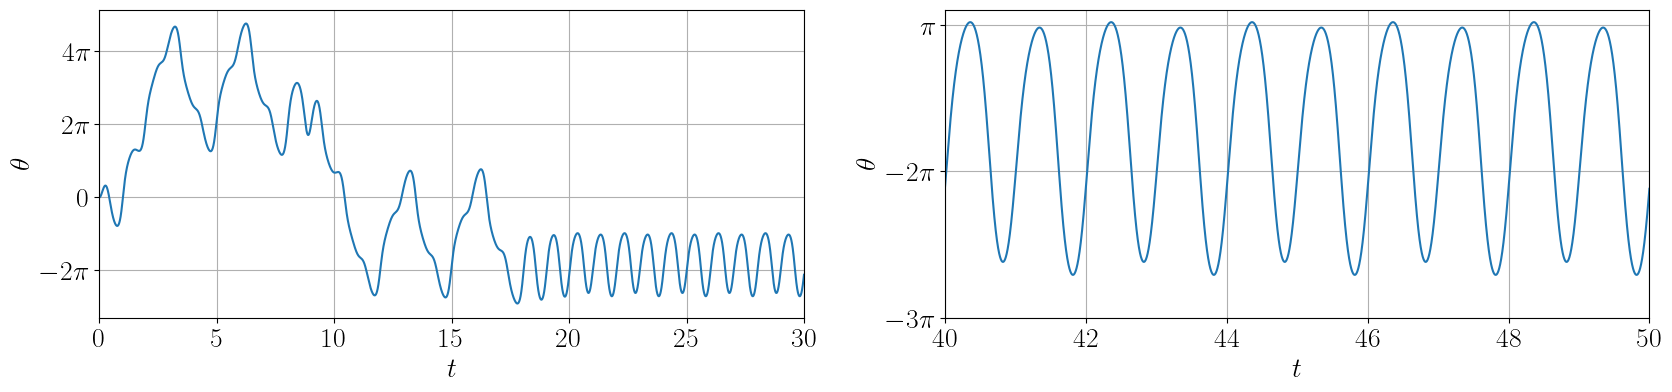

In [7]:
theta0     = 0                         # initial angle
theta_dot0 = 0.0                   # initial angular velocity
t_span     = [0, 50]
dt         = 0.001
gamma      = 1.073
omega      = 2*np.pi
omega_o    = 1.5*omega
beta       = omega_o/4
params     = beta, omega_o, gamma, omega 
x0         = [theta0, theta_dot0]
t, sol     = RK4(damped_driven_pendulum, t_span, params, dt, x0)
theta, theta_dot = sol[:,0], sol[:,1]

fig, ax = plt.subplots(1,2, figsize=(20,4))
ax[0].plot(t[:int(30/dt)], theta[:int(30/dt)])
ax[0].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$\theta$')
ax[0].set_xlim([0,30])
ax[0].grid(True)
ax[0].set_yticks([-2*np.pi, 0, 2*np.pi, 4*np.pi], [r'$-2\pi$',r'$0$',r'$2\pi$',r'$4\pi$'])

ax[1].plot(t[int(40/dt):], theta[int(40/dt):])
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$\theta$')
ax[1].set_xlim([40,50])
ax[1].grid(True)
ax[1].set_yticks([-3*np.pi, -2*np.pi, -np.pi], [r'$-3\pi$',r'$-2\pi$',r'$\pi$'])
plt.show()

**12.10** Explore the behavior of the DDP with the same parameters as in Problem 12.8, but with several different initial conditions.      
$ \qquad \ $ For example, you might keep $\dot{\phi}(0) = 0$ but try various different values for $\phi(0)$ between $\pi$ and $\pi$.         
$ \qquad \ $ You will find that the initial behavior varies quite a lot according to the initial conditions, but the long-term motion is the same in all cases                                                                                                             
$ \qquad \ $ (as long as you remember that values of $\phi$ that differ by multiples of $2\pi$ represent the same position).

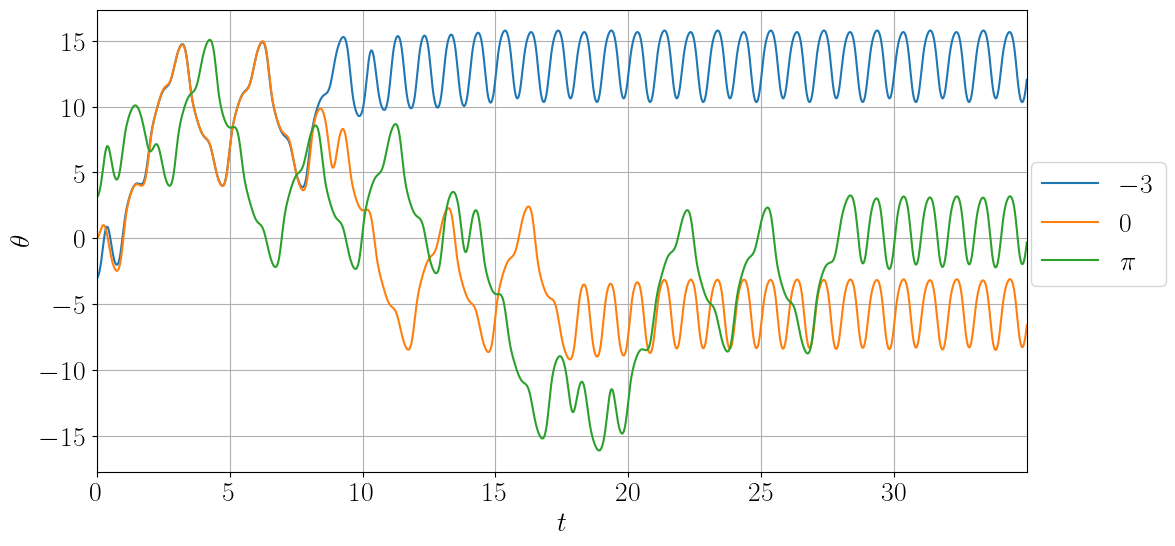

In [8]:
theta0     = [-3, 0, np.pi]            # initial angle
theta_dot0 = 0.0                   # initial angular velocity
t_span     = [0, 35]
dt         = 0.01
gamma      = 1.073
omega      = 2*np.pi
omega_o    = 1.5*omega
beta       = omega_o/4
params     = beta, omega_o, gamma, omega 

fig, ax = plt.subplots(figsize=(12,6))
for i, theta0 in enumerate(theta0):
    x0 = [theta0, theta_dot0]
    t, sol = RK4(damped_driven_pendulum, t_span, params, dt, x0)
    theta, theta_dot = sol[:,0], sol[:,1]
    ax.plot(t, theta)
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$\theta$')
    ax.set_xlim([t.min(),t.max()])
ax.legend([r'$-3$',r'$0$',r'$\pi$'], bbox_to_anchor=(0.99, 0.7), fontsize=20)
ax.grid()
plt.show()

### A deep study through Bifurcation Diagram

Construct the bifurcation diagrams for the **Damped Driven Pendulum** system by integrating the equations of motion and systematically varying                                                                                                           
the driving strength $\gamma $, from $t = 0 $ to a time $t_{max}$ picked so that all transients have long since died out, along with the following parameters :                                                                                                                  
$ \qquad \ $  drive frequency $\omega = 2\pi ,$                                                                                                         
$ \qquad \ $  natural frequency $\omega_o = 1.5\omega ,$                                                                                               
$ \qquad \ $  damping constant $\displaystyle\beta=\frac{\omega_o}{4},$                                                                                 
$ \qquad \ $  initial conditions $\phi(0)=-\frac{\pi}{2}, \ \dot{\phi}(0)=0$.                                                                                
Analyze the transition between periodic and chaotic behavior of the angular position $\theta$ and angular velocity $\dot{\theta}$  at stroboscopic intervals as a function of $\gamma ?$                                                             
And verify that you get the result shown in Figure 12.17 and Figure 12.18

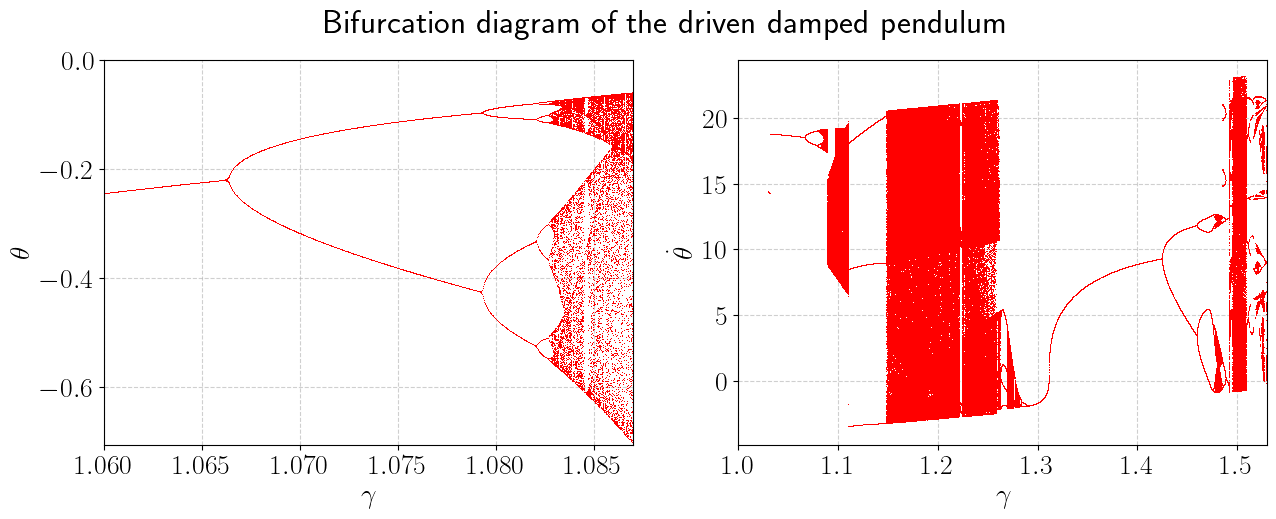

In [8]:
omega   = 2 * np.pi                                      # Frequency of the driving force
omega_o = 1.5 * omega                                    # Natural frequency
beta    = omega_o / 4                                    # Damping coefficient
dt      = 0.01                                           # Time step
t_span  = [0, 600]                                       # Time span
x0      = [-np.pi/2 , 0.0]                               # Initial conditions [theta0, theta_dot0]
sampler = [int(x/dt) for x in range(500, 600)]
th, dth = [], []

for gamma in np.linspace(1.06, 1.087, 1000):             # Amplitude of the driving force
    params = (beta, omega_o, gamma, omega)
    t, sol = RK4(damped_driven_pendulum, t_span, params, dt, x0)
    theta, theta_dot = sol[:, 0],sol[:, 1]
    ySamples = theta[sampler]
    Appended = [[gamma, yVal] for yVal in ySamples]
    th.extend(Appended)
    
for gamma in np.linspace(1.03, 1.53, 20000):               # Amplitude of the driving force
    params = (beta, omega_o, gamma, omega)
    t, sol = RK4(damped_driven_pendulum, t_span, params, dt, x0)
    theta, theta_dot = sol[:, 0],sol[:, 1]
    ySamples = theta_dot[sampler]
    Appended = [[gamma, yVal] for yVal in ySamples]
    dth.extend(Appended)
    
theta_bif, theta_dot_bif = np.array(th), np.array(dth)
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Bifurcation diagram of the driven damped pendulum')
ax[0].plot(theta_bif[:, 0], theta_bif[:, 1], 'r,', ms=0.6)
ax[0].set_xlabel(r'$\gamma$')
ax[0].set_ylabel(r'$\theta$')
ax[0].set_xlim([theta_bif[:, 0].min(), theta_bif[:, 0].max()])
ax[0].set_ylim([theta_bif[:, 1].min(), 0])
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].plot( theta_dot_bif[:, 0],   theta_dot_bif[:, 1], 'r,', ms=0.6)
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel(r'$\dot{\theta}$')
ax[1].set_xlim([1, theta_dot_bif[:, 0].max()])
ax[1].grid(True, linestyle='--', alpha=0.6)
plt.show()

##### Trying to find the Bifurcation points of $\gamma$

In [6]:
def aggregate_theta_points_by_gamma(R, X):
    aggregated_theta = defaultdict(list)
    for r, x in zip(R, X):
        if isinstance(x, (np.ndarray, list)):
            aggregated_theta[r].append(x)       
        else:
            aggregated_theta[r].append([x])  
    return aggregated_theta

def find_max_theta_points_per_gamma(aggregated_theta):
    theta_max_per_gamma = {}
    for r, theta_points in aggregated_theta.items():
        all_theta_values = []
        for points in theta_points:
            if isinstance(points, np.ndarray):
                all_theta_values.extend(points)  
            else:
                all_theta_values.extend(np.array(points))         
        all_theta_values       = np.array(all_theta_values)
        unique_theta_values    = np.unique(np.round(all_theta_values, decimals=5))
        num_unique             = len(unique_theta_values)        
        theta_max_per_gamma[r] = num_unique    
    return theta_max_per_gamma

def detect_bifurcation_points(max_theta_points_per_gamma):
    bifurcation_info = []
    sorted_gamma = sorted(max_theta_points_per_gamma.keys())    
    for i in range(1, len(sorted_gamma)):
        prev_gamma    = sorted_gamma[i - 1]
        current_gamma = sorted_gamma[i]        
        prev_point    = max_theta_points_per_gamma[prev_gamma]
        current_point = max_theta_points_per_gamma[current_gamma]
        if abs(current_point - prev_point) > 10: 
            bifurcation_info.append((current_gamma, current_point)) 
    return bifurcation_info

def find_local_maxima(bifurcation_info):
    local_maxima = []
    for i in range(1, len(bifurcation_info) - 1):
        prev_gamma, prev_points = bifurcation_info[i - 1]
        curr_gamma, curr_points = bifurcation_info[i]
        next_gamma, next_points = bifurcation_info[i + 1]
        if curr_points > prev_points and curr_points > next_points:
            local_maxima.append((curr_gamma, curr_points))
    return local_maxima

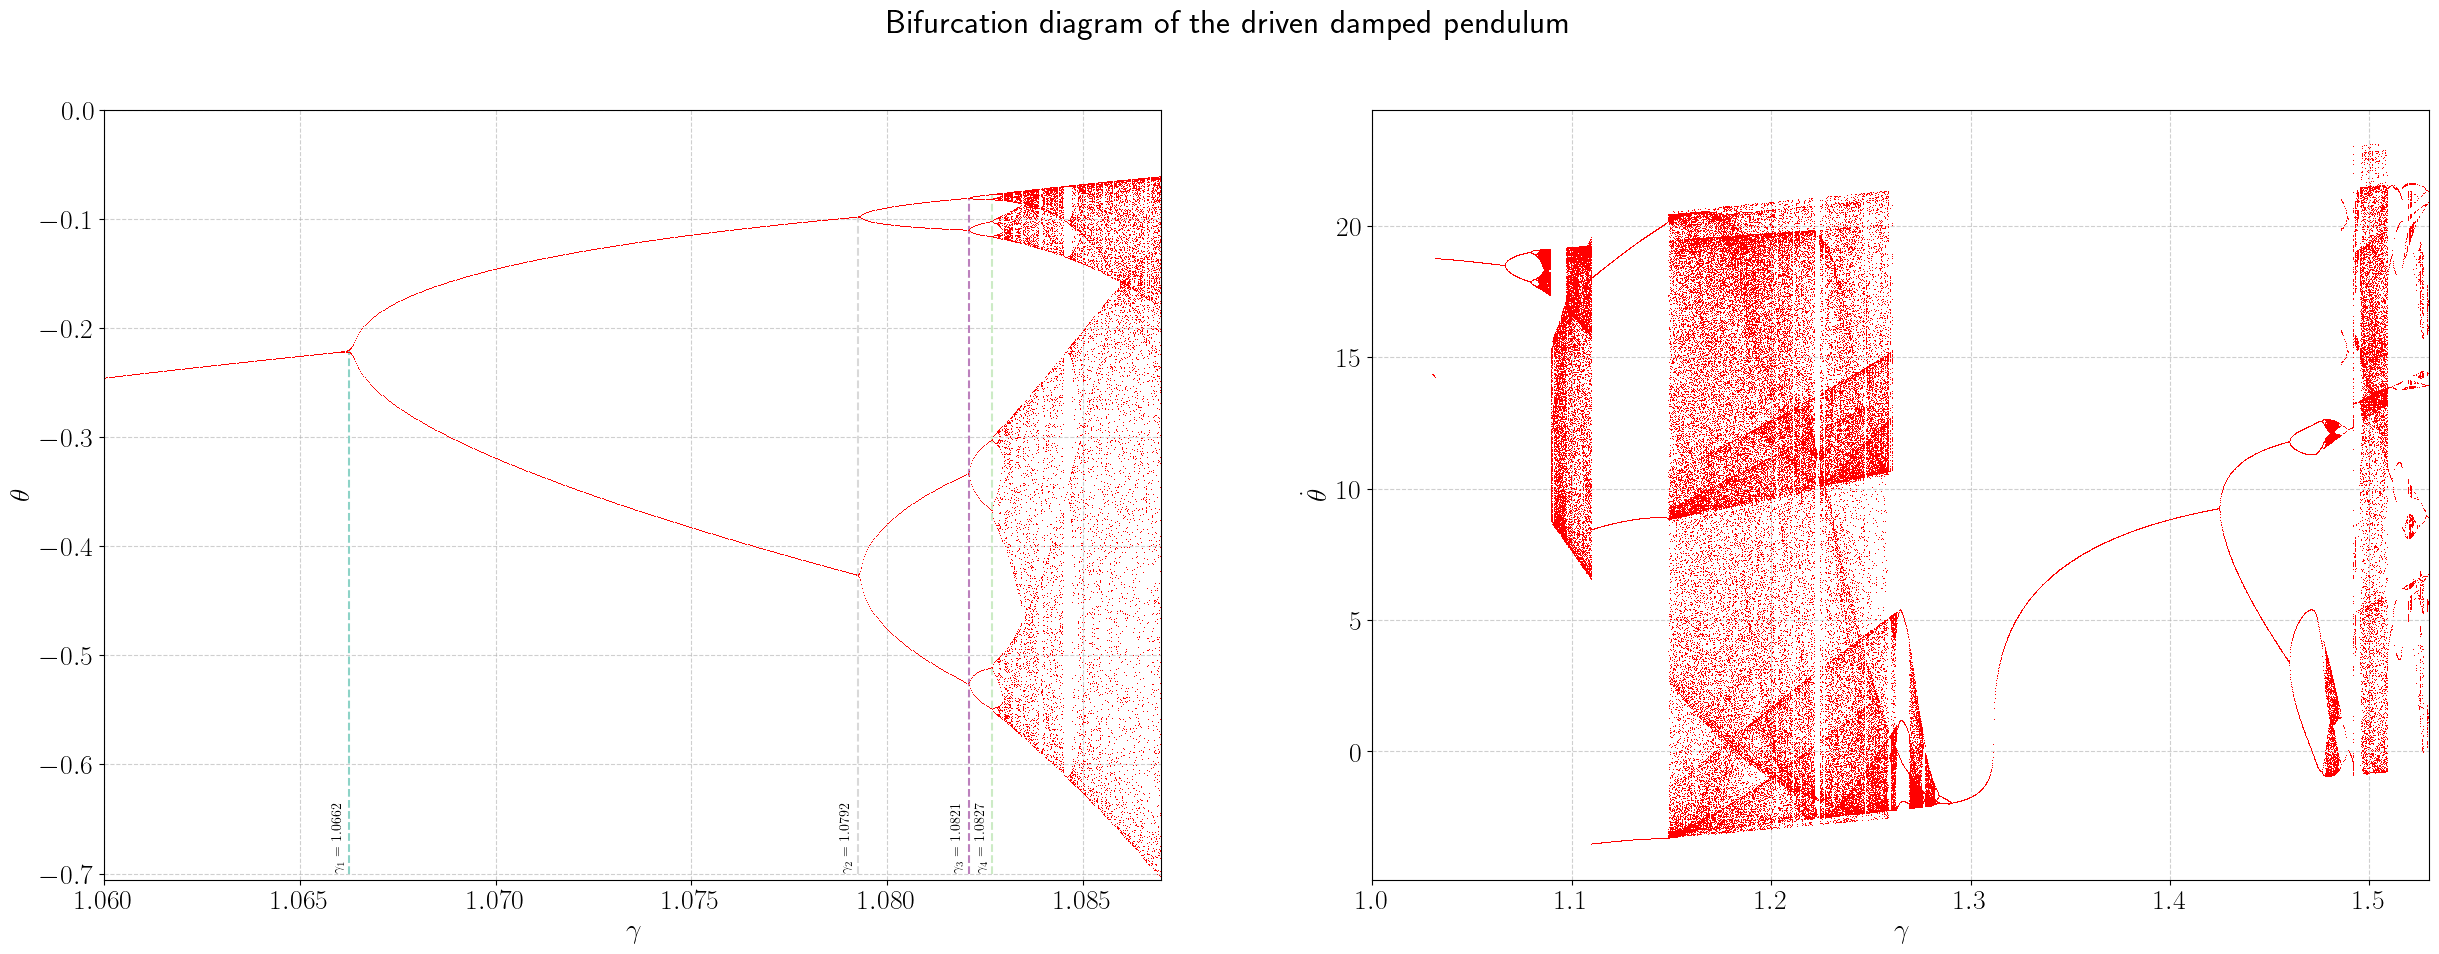

In [21]:
aggregated_gamma_theta     = aggregate_theta_points_by_gamma(theta_bif[:, 0], theta_bif[:, 1])
max_theta_points_per_gamma = find_max_theta_points_per_gamma(aggregated_gamma_theta)
bifurcation_information    = detect_bifurcation_points(max_theta_points_per_gamma)
local_maxima_for_gamma     = find_local_maxima(bifurcation_information)
gamma_values_from_theta    = [gamma for gamma, _ in local_maxima_for_gamma]

fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Bifurcation diagram of the driven damped pendulum')
norm = mcolors.Normalize(vmin=min(gamma_values_from_theta), vmax=max(gamma_values_from_theta))
cmap = cm.get_cmap('Set3')

for i,gamma in enumerate(gamma_values_from_theta[:4]):
    Gi = np.where(np.round(theta_bif[:, 0], 4) == np.round(gamma, 4))
    if len(Gi[0]) > 0: 
        Tmin,Tmax,Gp = -0.7,theta_bif[Gi,1].max(),gamma-0.0002  
        ax[0].vlines(x=gamma, ymin=Tmin, ymax=Tmax, linestyle="--", color=cmap(norm(gamma)))
        ax[0].text(Gp,Tmin,f'$\\gamma_{i+1} = {gamma:.4f}$',
                   fontsize=10,rotation=90,rotation_mode='anchor',transform_rotates_text=True)
ax[0].plot(theta_bif[:, 0], theta_bif[:, 1], 'r,', ms=0.2)
ax[0].set_xlabel(r'$\gamma$')
ax[0].set_ylabel(r'$\theta$')
ax[0].set_xlim([theta_bif[:, 0].min(), theta_bif[:, 0].max()])
ax[0].set_ylim([theta_bif[:, 1].min(), 0])
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].plot( theta_dot_bif[:, 0],   theta_dot_bif[:, 1], 'r,', ms=0.2)
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel(r'$\dot{\theta}$')
ax[1].set_xlim([1, theta_dot_bif[:, 0].max()])
ax[1].grid(True, linestyle='--', alpha=0.6)
plt.show()

#### A deep study of the $\dot{\theta}$ vs. $\gamma$ bifurcation graph

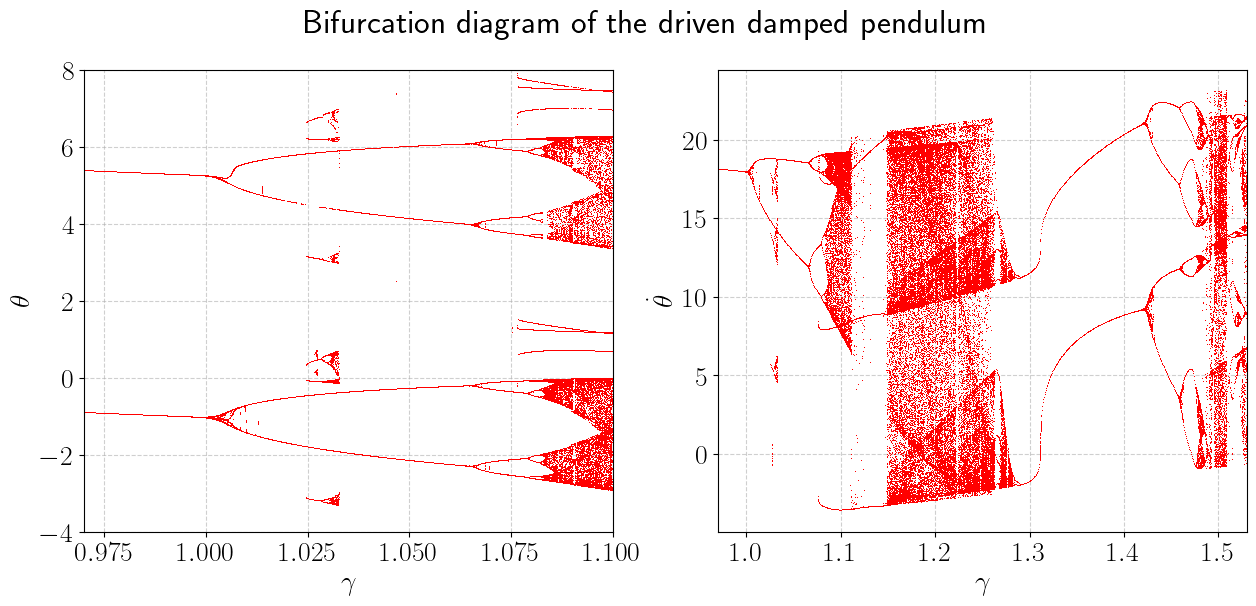

In [23]:
omega   = 2 * np.pi                                      # Frequency of the driving force
omega_o = 1.5 * omega                                    # Natural frequency
beta    = omega_o / 4                                    # Damping coefficient
dt      = 0.01                                           # Time step
t_span  = [0, 60]                                        # Time span
sampler = [int(x/dt) for x in range(50, 60)]
th, dth = [], []
X = [-np.pi,-11*np.pi/12,-5*np.pi/6,-3*np.pi/4,-2*np.pi/3,-7*np.pi/12,
     -np.pi/2, -5*np.pi/12,-np.pi/3,-np.pi/4,-np.pi/6,-np.pi/12,
     0,np.pi/12, np.pi/6, np.pi/4, np.pi/3, 5*np.pi/12,np.pi/2,7*np.pi/12,
     2*np.pi/3,3*np.pi/4, 5*np.pi/6, 11*np.pi/12, np.pi]

for x0 in X:
    intit = [x0, 0.]
    for gamma in np.linspace(0.97, 1.1, 20000):               # Amplitude of the driving force
        params = (beta, omega_o, gamma, omega)
        t, sol = RK4(damped_driven_pendulum, t_span, params, dt, intit)
        theta, theta_dot = sol[:, 0],sol[:, 1]
        yS = theta[sampler]
        AppendedY  = [[gamma, yVal] for yVal in yS]
        th.extend(AppendedY)
    for gamma in np.linspace(0.97, 1.53, 20000):               # Amplitude of the driving force
        params = (beta, omega_o, gamma, omega)
        t, sol = RK4(damped_driven_pendulum, t_span, params, dt, intit)
        theta, theta_dot = sol[:, 0],sol[:, 1]
        dyS = theta_dot[sampler]
        AppendedYd = [[gamma, yVal] for yVal in dyS]
        dth.extend(AppendedYd)
        
theta_bif, theta_dot_bif = np.array(th), np.array(dth)

fig, ax = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Bifurcation diagram of the driven damped pendulum')
ax[0].plot(theta_bif[:, 0], theta_bif[:, 1], 'r,', ms=0.6)
ax[0].set_xlabel(r'$\gamma$')
ax[0].set_ylabel(r'$\theta$')
ax[0].set_xlim([theta_bif[:, 0].min(), theta_bif[:, 0].max()])
ax[0].set_ylim([-4.,8.])
ax[0].grid(True, linestyle='--', alpha=0.6)

ax[1].plot( theta_dot_bif[:, 0],   theta_dot_bif[:, 1], 'r,', ms=0.6)
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel(r'$\dot{\theta}$')
ax[1].set_xlim([theta_dot_bif[:, 0].min(), theta_dot_bif[:, 0].max()])
ax[1].grid(True, linestyle='--', alpha=0.6)
plt.show()

---

**12.11** Test how well the values of the thresholds $\gamma_n$ given in Table 12.1 fit the Feigenbaum relation (12.17) as follows:     
                                                                                                                               
$ \qquad \ $ (a) Assuming that the Feigenbaum relation is exactly true use it to prove that $\displaystyle\big(\gamma_{n+1} - \gamma_n \big) = \frac{1}{\delta^{n-1}}\big(\gamma_2 - \gamma_1 \big) $                                                               
$ \qquad \quad \ \ $  and, hence, that a plot of $\ln\big(\gamma_{n+1} - \gamma_n \big)$ against $n$ should be a straight line with slope $-\ln\delta$                                       
$ \qquad \ $ (b) Make this plot for the three differences of Table 12.1.  How well do your points seem to bear out our prediction?           
$ \qquad \quad \ \ $  Fit a line to your plot (either graphically or using a least squares fit) and find the slope and hence the Feigenbaum number $\delta$.                                                                                                                            
$ \qquad \ $  [ You would not expect to get very good agreement with the known value (12.18) for two reasons :                               
$ \qquad \quad $  You have only three points to plot and the Feigenbaum relation (12.17) is only approximate, except in the limit of large $n$.          
$ \qquad \quad $  Under the circumstances, you will find the agreement is remarkable.]
                                                                                                                 

From 12.17 ,                                                                                                                                        
$\qquad\displaystyle\big(\gamma_{n+1} - \gamma_n \big) = \frac{1}{\delta}\big(\gamma_n - \gamma_{n-1} \big) = \frac{1}{\delta^2}\big(\gamma_{n-1} - \gamma_{n-2} \big) = \dots = \frac{1}{\delta^{n-1}}\big(\gamma_2 - \gamma_1 \big) $                     
Now taking $\ln$ on both side we get,                                                                                                
$\qquad\displaystyle\ln\big(\gamma_{n+1} - \gamma_n \big)=\ln \frac{1}{\delta^{n-1}}\big(\gamma_2 - \gamma_1 \big) = \frac{\ln\big(\gamma_2 - \gamma_1 \big)}{\ln \delta^{n-1}} = \ln\big(\gamma_2 - \gamma_1 \big) - \ln \delta^{n-1} = \ln\big(\gamma_2 - \gamma_1 \big) - (n-1)\ln \delta $                                                                                       
On comparing with $Y=mX+c$ we get,                                                                                                      
$\qquad\displaystyle\ln\big(\gamma_{n+1} - \gamma_n \big)= Y, \quad \ln\big(\gamma_2 - \gamma_1 \big) = c , \quad -\ln \delta = m => \delta=e^{-m}, \quad n-1 = X => n=X+1$

In [12]:
def fit(x,y):
    n   = len(x)
    sx  = sum(x)
    sy  = sum(y)
    sx2 = sum(x*x)
    sxy = sum(x*y)
    b   = (n*sx2 - sx**2)
    m   = (n*sxy - sx*sy) / b
    c   = (sy*sx2 - sx*sxy) / b
    return m,c

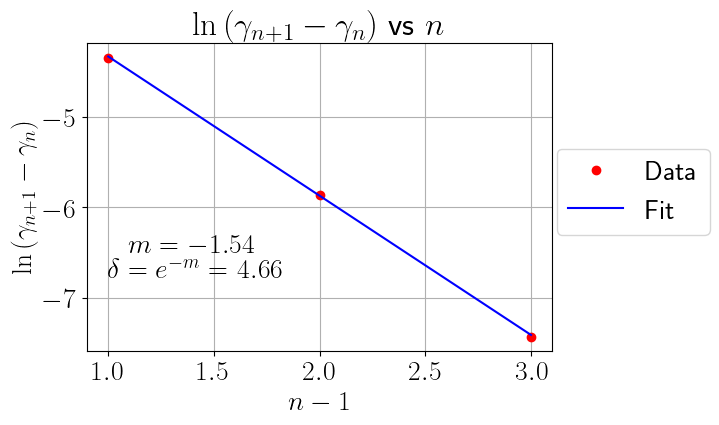

In [13]:
gamma_v    = gamma_values_from_theta[:4]                        # From the Bifurcation Diagram 
#gamma_v   = [1.0663, 1.0793, 1.0821, 1.0827]                   # Data from Taylor's Book
n          = len(gamma_v)
n_values   = np.arange(1, n + 1)
gamma_dlog = np.log(np.diff(gamma_v))
m, c       = np.round(fit(n_values[:n-1], gamma_dlog),2)
Y          = m*np.array(n_values[:n-1]) + c
delta      = np.exp(-m)

plt.figure(figsize=(6, 4))
plt.plot(n_values[:n-1], gamma_dlog, 'ro', label='Data')
plt.plot(n_values[:n-1], Y, 'b-', label='Fit')
plt.text(1, -6.5, f'$m = {m:.2f}$'+r' $\\ \delta=e^{-m}=$ '+f'${delta:.2f}$')
plt.xlabel('$n-1$')
plt.ylabel(r'$\ln\left(\gamma_{n+1} - \gamma_n\right)$')
plt.title(r'$\ln\left(\gamma_{n+1} - \gamma_n\right)$ vs $n$')
plt.grid(True)
plt.legend( bbox_to_anchor=(0.98, 0.7), fontsize=20)
plt.show()

**12.12** Here is another way to look at the Feigenbaum relation (12.17) :                                                              
$ \qquad \ $ (a) Assuming that (12.17) is exactly true, prove that the thresholds $\gamma_n$, approach a finite limit $\gamma_c$, and then prove that $\gamma_n = \gamma_c - K/\delta^n$ where $K$ is a constant.                                                     
$ \qquad \quad \ \ $ This means that a plot of $\gamma_n$ against $\delta^{-n}$ should be a straight line.                                         
$ \qquad \ $ (b) Using the known value (12.18) of $\delta=4.6692016$ and the four values of $\gamma_n$ in Table 12.1 make this plot. Does it seem to fit our prediction?                                                                                                              
$ \qquad \quad \ \ $  The vertical intercept of your graph should be $\gamma_c$ . What is your value and how well does it agree with (12.20) $ \quad i.e. , \quad \gamma_c = 1.0829 \ ?$

From 12.17,                                                                                                       
$\qquad\displaystyle\big(\gamma_{n+1} - \gamma_n \big) = \frac{1}{\delta^{n-1}}\big(\gamma_2 - \gamma_1 \big) $                     
Replacing $n$ by $n-1$                                                                                                      
$\qquad\displaystyle\big(\gamma_{n} - \gamma_{n-1} \big) = \frac{C}{\delta^{n}} \qquad\qquad[\because C=\text{constant}] $                                                      
$\qquad\displaystyle \gamma_{n} = \gamma_{n-1}  + \frac{C}{\delta^{n}} = \gamma_{n-2} + \frac{C}{\delta^{n-1}+\delta^{n}} = \dots = \gamma_1 + \frac{C}{\delta^2+\delta^3+\dots\delta^{n}}$                                                                                                            
This approaches a finite limit as $n\rightarrow\infty$                                                                            
$\qquad\displaystyle \gamma_{c} = \gamma_1 + \frac{C}{\delta^2+\delta^3+\dots}$                                                            
Taking the difference of the last two equations, we see that                                                                              
$\qquad\displaystyle \gamma_{n} = \gamma_{c} - \frac{C}{\delta^{n+1}+\delta^{n+2}+\dots}$                                                 
$\qquad\displaystyle \gamma_{n} = \gamma_{c} - \frac{C}{\delta^n\big(\delta^{1}+\delta^{2}+\dots \big)}$                            
$\qquad\displaystyle \gamma_{n} = \gamma_{c} - \frac{K}{\delta^n}  \qquad\qquad \Bigg[\because K = \frac{C}{\big(\delta^{1}+\delta^{2}+\dots \big)} =\text{constant}\Bigg]  $                                                                                           
Comparing with $y=mx+c$                                                                                                       
$\qquad\displaystyle \gamma_{n} = y , \ \gamma_{c}=c , \  \frac{1}{\delta^n}=x , \ K=m $

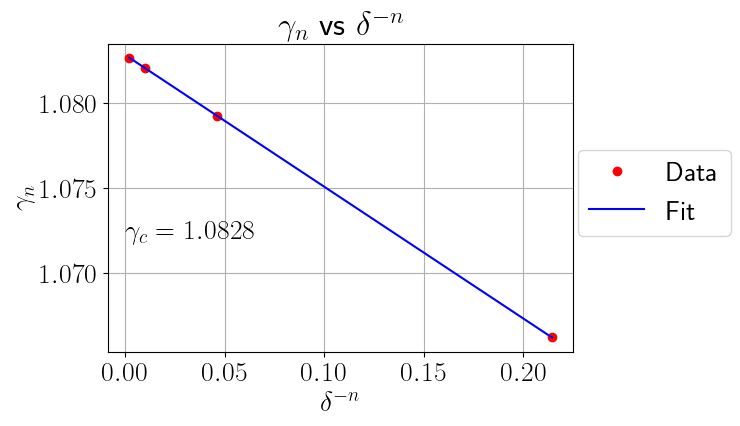

In [14]:
#delta     = 4.6692016                                   # Data from Taylor's Book
delta_inv = np.array([delta**(-n) for n in n_values])
m, Gc     = fit(delta_inv, gamma_v)
y         = m*delta_inv + Gc

plt.figure(figsize=(6, 4))
plt.plot(delta_inv, gamma_v, 'ro', label='Data')
plt.plot(delta_inv, y, 'b-', label='Fit')
plt.text(0, 1.072, f'$\gamma_c={Gc:.4f}$')
plt.xlabel(r'$\delta^{-n}$')
plt.ylabel(r'$\gamma_n$')
plt.title(r'$\gamma_n$ vs $\delta^{-n}$')
plt.legend(bbox_to_anchor=(0.98, 0.7), fontsize=20)
plt.grid(True)
plt.show()

**12.13** You can see in Figure 12.13 that for $\gamma = 1.105,$ the separation of two identical pendulums with slightly different initial conditions increases exponentially.                                                                                 
$ \qquad \ \ $ Specifically $\Delta\phi$ starts out at $10^{-4}$ and by $t = 14.5$ it has reached about $1$. Use this to estimate the Liapunov exponent $\lambda$ as defined in (12.26), $\Delta\phi(t)\sim K e^{\lambda t}$ .                   
$ \qquad \ \ $ Your answer should confirm that $\lambda > 0$ for chaotic motion.                                                                                                                                                

                                                                                                                                      
Given : $ \ t=14.5 \ , \quad \phi(0)=10^{-4} \ , \quad \phi(t=14.5)=1$                                                                             
From 12.26,                                                                                                                                                       
$\qquad \begin{align} &{\therefore} \qquad |\Delta\phi(t)| \sim Ke^{\lambda t} \\ &{or}, \qquad\Delta\phi(t) = \Delta\phi(0) e^{\lambda t} \\  &{or}, \quad\frac{\Delta\phi(t)}{\Delta\phi(0)} \ \ = e^{\lambda t} \end{align}$                                                                                                
Taking $\log$ on both sides,                                                                                                       
$\qquad\begin{align} \ln\bigg(\frac{\Delta\phi(t)}{\Delta\phi(0)}\bigg) &= \ln(e^{\lambda t}) = \lambda t \\ or, \qquad
\lambda &= \frac{1}{t}\ln\bigg(\frac{\Delta\phi(t)}{\Delta\phi(0)}\bigg) = \frac{1}{14.5}\times\ln\bigg(\frac{1}{10^{-4}}\bigg) \approx 0.64 > 0 \text{ (verified)} \end{align}$ .                                                                

---
##### Deep Study of DPP Exponentials - Lyapunov's 

Numerically solve the equation of motion (12.11) for a damped driven pendulum (DDP) with :                                   
$ \qquad \ $  drive strength $\gamma = 0.1$,                                                                                                            
$ \qquad \ $  drive frequency $\omega = 2\pi$,                                                                                                          
$ \qquad \ $  natural frequency $\omega_0 = 1.5\omega$,                                                                                                
$ \qquad \ $  damping constant $\displaystyle\beta = \frac{\omega_0}{4}$,                                                                                          
$ \qquad \ $  initial conditions $\theta(0) = -\frac{\pi}{2}$, $\dot{\theta}(0) = 0$.                                                                                                          
1. Integrate the equation over the time interval $t \in [0, 10]$. Plot $\theta(t)$ to confirm that the motion settles into **regular oscillations**.                                                                                            
2. To explore the system’s sensitivity to initial conditions, repeat the same parameters with initial positions that differ by $0.1$ radians (or about $6°$).                                                                                                     
Call the solutions $\theta_1(t)$ and $\theta_2(t)$ respectively. Plot $\log_{10} |\Delta\theta(t)|$, where $\Delta\theta(t) = \theta_2(t) - \theta_1(t)$.                                                       
Does the distance between the trajectories decay exponentially (suggesting a **negative Lyapunov exponent**) ?                      

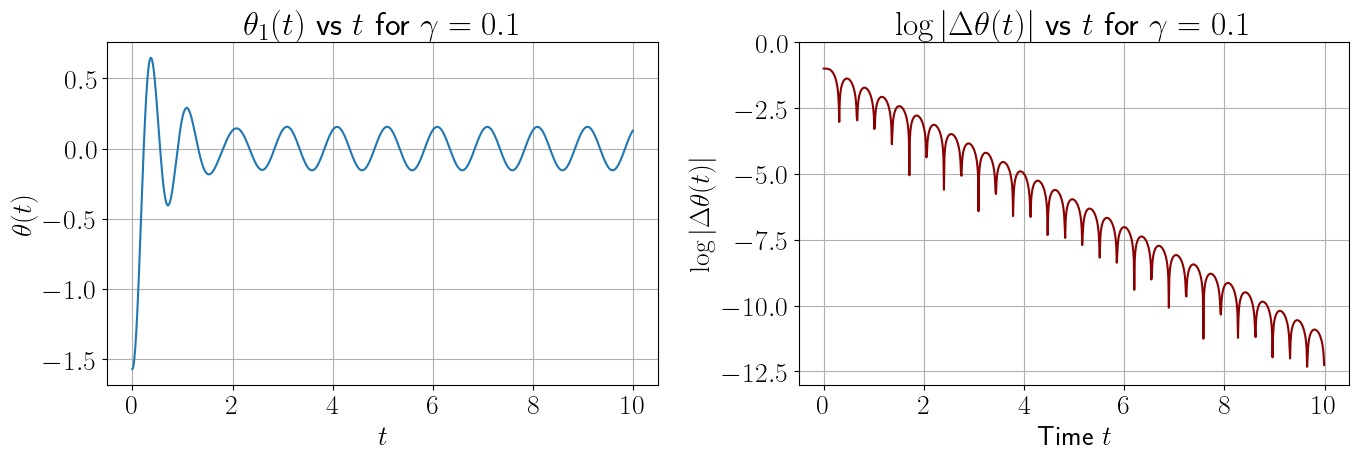

In [22]:
omega   = 2 * np.pi
omega_o = 1.5 * omega
beta    = omega_o / 4
gamma   = 0.1
params  = [beta, omega_o, gamma, omega]
t_span  = [0, 10]   
dt      = 0.01
x0_1    = [-np.pi/2, 0.0]
x0_2    = [-np.pi/2 + 0.1, 0.0]
t, sol1 = RK4(damped_driven_pendulum, t_span, params, dt, x0_1)
_, sol2 = RK4(damped_driven_pendulum, t_span, params, dt, x0_2)
theta1  = sol1[:, 0]  
theta2  = sol2[:, 0]  
dtheta  = np.abs(theta1 - theta2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(t, theta1)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\theta(t)$')
ax1.set_title(r'$\theta_1(t)$ vs $t$ for '+f'$\\gamma={gamma}$')
ax1.grid(True)

ax2.plot(t, np.log10(dtheta), color='darkred')
ax2.set_xlabel('Time $t$')
ax2.set_ylabel(r'$\log|\Delta \theta(t)|$')
ax2.set_title(r'$\log|\Delta \theta(t)|$ vs $t$ for '+f'$\\gamma={gamma}$')
ax2.set_ylim([-13, 0.])
ax2.grid(True)
plt.tight_layout()
plt.show()

Numerically solve the equation of motion (12.11) for a damped driven pendulum (DDP) with :                                   
$ \qquad \ $  drive strength $\gamma = 1.07$,                                                                                                                   
$ \qquad \ $  drive frequency $\omega = 2\pi$,                                                                                                               
$ \qquad \ $  natural frequency $\omega_0 = 1.5\omega$,                                                                                                      
$ \qquad \ $  damping constant $\displaystyle\beta = \frac{\omega_0}{4}$,                                                                                                   
$ \qquad \ $  initial conditions $\theta(0) = -\frac{\pi}{2}$, $\dot{\theta}(0) = 0$.                                                                                                        
1. Integrate the equation over the time interval $t \in [0, 40]$. Plot $\theta(t)$ to confirm that the motion settles into **regular oscillations**.                                                                                            
2. To explore the system’s sensitivity to initial conditions, repeat the same parameters with initial positions that differ by $0.1$ radians (or about $6°$).                                                                                         

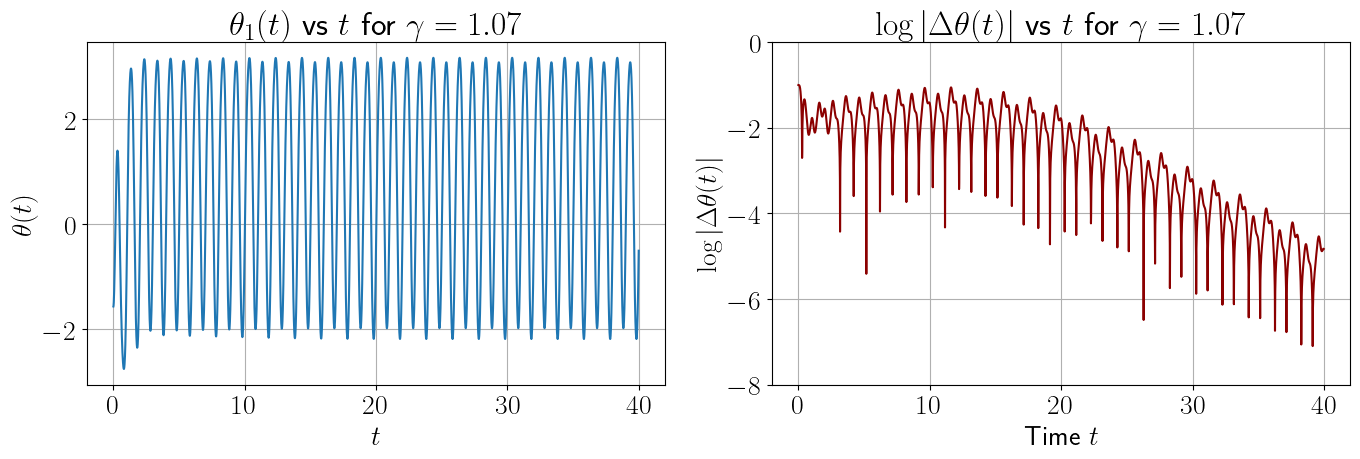

In [5]:
omega   = 2 * np.pi
omega_o = 1.5 * omega
beta    = omega_o / 4
gamma   = 1.07
params  = [beta, omega_o, gamma, omega]
t_span  = [0, 40]   
dt      = 0.01
x0_1    = [-np.pi/2, 0.0]
x0_2    = [-np.pi/2 + 0.1, 0.0]
t, sol1 = RK4(damped_driven_pendulum, t_span, params, dt, x0_1)
_, sol2 = RK4(damped_driven_pendulum, t_span, params, dt, x0_2)
theta1  = sol1[:, 0]  
theta2  = sol2[:, 0]  
dtheta  = abs(theta1 - theta2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(t, theta1)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\theta(t)$')
ax1.set_title(r'$\theta_1(t)$ vs $t$ for '+f'$\\gamma={gamma}$')
ax1.grid(True)

ax2.plot(t, np.log10(dtheta), color='darkred')
ax2.set_xlabel('Time $t$')
ax2.set_ylabel(r'$\log|\Delta \theta(t)|$')
ax2.set_title(r'$\log|\Delta \theta(t)|$ vs $t$ for '+f'$\\gamma={gamma}$')
ax2.set_ylim([-8., 0.])
ax2.grid(True)
plt.tight_layout()
plt.show()

Numerically solve the equation of motion (12.11) for a damped driven pendulum (DDP) with :                                   
$ \qquad \ $  drive strength $\gamma = 1.105$,                                                                                                                 
$ \qquad \ $  drive frequency $\omega = 2\pi$,                                                                                                                
$ \qquad \ $  natural frequency $\omega_0 = 1.5\omega$,                                                                                                        
$ \qquad \ $  damping constant $\displaystyle\beta = \frac{\omega_0}{4}$,                                                                                               
$ \qquad \ $  initial conditions $\theta(0) = -\frac{\pi}{2}$, $\dot{\theta}(0) = 0$.                                                                                      
1. Integrate the equation over the time interval $t \in [0, 30]$. Plot $\theta(t)$ to confirm that the motion settles into **regular period-3 oscillations**.                                                                                            
2. To explore the system’s sensitivity to initial conditions, repeat the same parameters with the initial difference to be just $\Delta\theta(0) = 0.0001$ radians.                                                                    

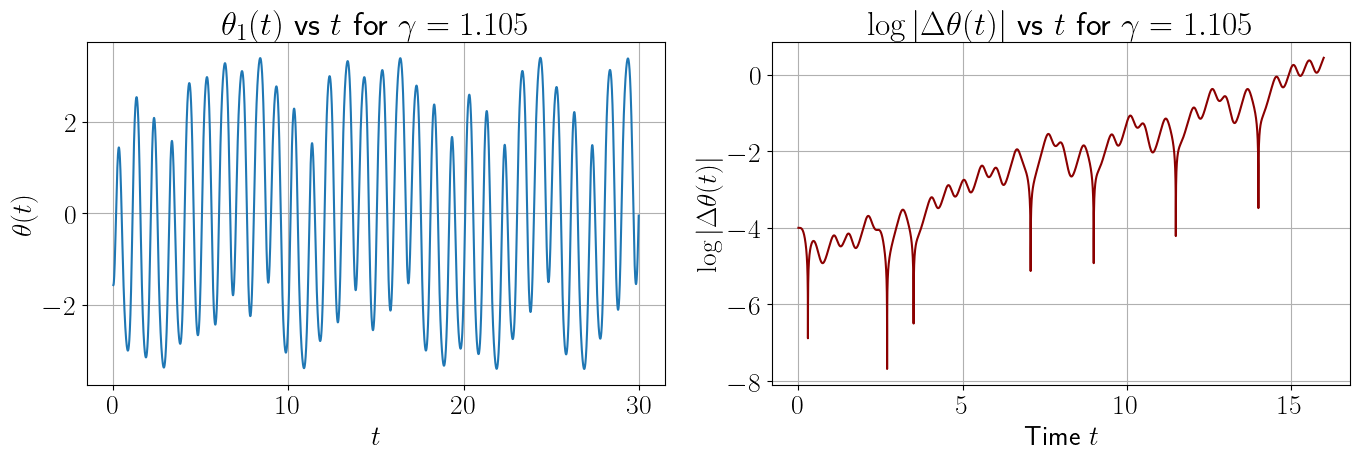

In [27]:
omega   = 2 * np.pi
omega_o = 1.5 * omega
beta    = omega_o / 4
gamma   = 1.105
params  = [beta, omega_o, gamma, omega]
t_span  = [0, 30]   
dt      = 0.001
x0_1    = [-np.pi/2, 0.0]
x0_2    = [-np.pi/2 + 1e-4, 0.0]

t, sol1 = RK4(damped_driven_pendulum, t_span, params, dt, x0_1)
_, sol2 = RK4(damped_driven_pendulum, t_span, params, dt, x0_2)
theta1  = sol1[:, 0]  
theta2  = sol2[:, 0]  
dtheta  = abs(theta1 - theta2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(t, theta1)
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\theta(t)$')
ax1.set_title(r'$\theta_1(t)$ vs $t$ for '+f'$\\gamma={gamma}$')
ax1.grid(True)

ax2.plot(t[:int(16/dt)], np.log10(dtheta[:int(16/dt)]), color='darkred')
ax2.set_xlabel('Time $t$')
ax2.set_ylabel(r'$\log|\Delta \theta(t)|$')
ax2.set_title(r'$\log|\Delta \theta(t)|$ vs $t$ for '+f'$\\gamma={gamma}$')
ax2.grid(True)
plt.tight_layout()
plt.show()

Numerically solve the equation of motion (12.11) for a damped driven pendulum (DDP) with :                                   
$ \qquad \ $  drive strength $\gamma = 1.13$,                                                                                                                    
$ \qquad \ $  drive frequency $\omega = 2\pi$,                                                                                                               
$ \qquad \ $  natural frequency $\omega_0 = 1.5\omega$,                                                                                                      
$ \qquad \ $  damping constant $\displaystyle\beta = \frac{\omega_0}{4}$,                                                                                               
$ \qquad \ $  initial conditions $\theta(0) = -\frac{\pi}{2}$, $\dot{\theta}(0) = 0$.                                                                                     
1. Integrate the equation over the time interval $t \in [0, 20]$. Plot $\theta(t)$ to confirm that the motion settles into **regular oscillations**.                                                                                                               
2. To explore the system’s sensitivity to initial conditions, repeat the same parameters with its initial angle $0.001$ radians lower.                                                                                                                         

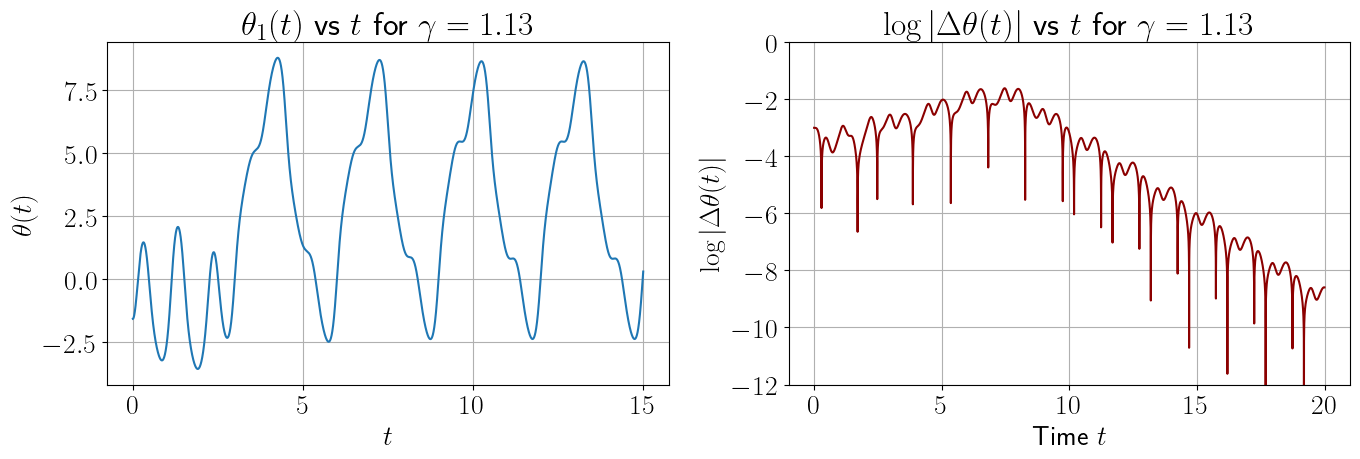

In [7]:
omega   = 2 * np.pi
omega_o = 1.5 * omega
beta    = omega_o / 4
gamma   = 1.13
params  = [beta, omega_o, gamma, omega]
t_span  = [0, 20]   
dt      = 0.001
x0_1    = [-np.pi/2, 0.0]
x0_2    = [-np.pi/2 - 0.001, 0.0]

t, sol1 = RK4(damped_driven_pendulum, t_span, params, dt, x0_1)
_, sol2 = RK4(damped_driven_pendulum, t_span, params, dt, x0_2)
theta1  = sol1[:, 0]  
theta2  = sol2[:, 0]  
dtheta  = abs(theta1 - theta2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(t[:int(15/dt)], theta1[:int(15/dt)])
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\theta(t)$')
ax1.set_title(r'$\theta_1(t)$ vs $t$ for '+f'$\\gamma={gamma}$')
ax1.grid(True)

ax2.plot(t, np.log10(dtheta), color='darkred')
ax2.set_xlabel('Time $t$')
ax2.set_ylabel(r'$\log|\Delta \theta(t)|$')
ax2.set_title(r'$\log|\Delta \theta(t)|$ vs $t$ for '+f'$\\gamma={gamma}$')
ax2.set_ylim([-12, 0.])
ax2.grid(True)
plt.tight_layout()
plt.show()

Numerically solve the equation of motion (12.11) for a damped driven pendulum (DDP) with :                                   
$ \qquad \ $  drive strength $\gamma = 1.503$,                                                                                                                 
$ \qquad \ $  drive frequency $\omega = 2\pi$,                                                                                                            
$ \qquad \ $  natural frequency $\omega_0 = 1.5\omega$,                                                                                                         
$ \qquad \ $  damping constant $\displaystyle\beta = \frac{\omega_0}{4}$,                                                                                                    
$ \qquad \ $  initial conditions $\theta(0) = -\frac{\pi}{2}$, $\dot{\theta}(0) = 0$.                                                                                     
1. Integrate the equation over the time interval $t \in [0, 20]$. Plot $\theta(t)$ to confirm that the motion settles into **regular period-3 oscillations**.                                                                                            
2. To explore the system’s sensitivity to initial conditions, repeat the same parameters with an initial separation of $0.001$ radians.                                                                                                        

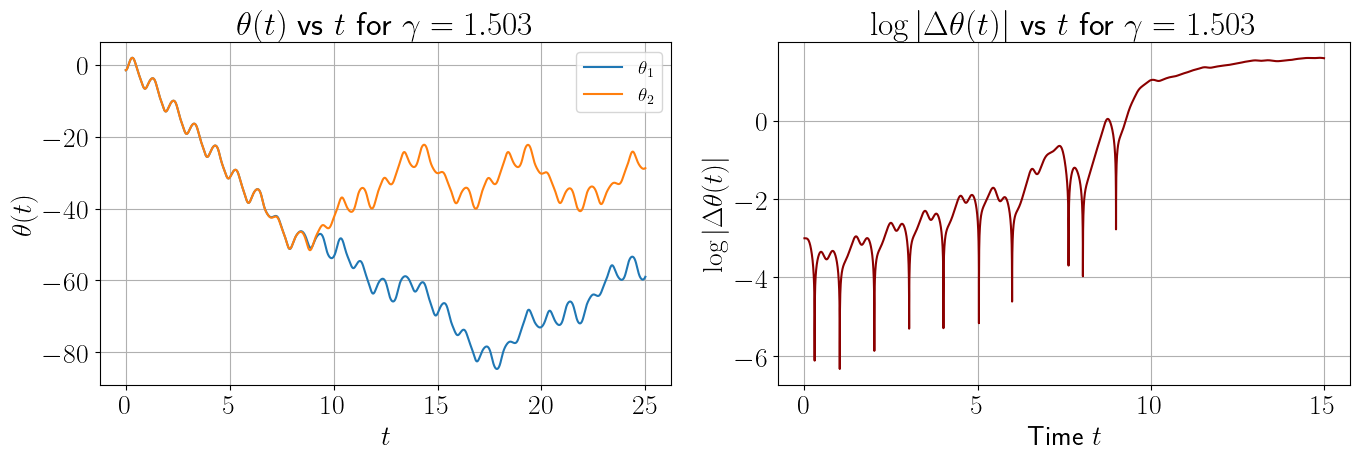

In [5]:
omega   = 2 * np.pi
omega_o = 1.5 * omega
beta    = omega_o / 4
gamma   = 1.503
params  = [beta, omega_o, gamma, omega]
t_span  = [0, 25]   
dt      = 0.001
x0_1    = [-np.pi/2, 0.0]
x0_2    = [-np.pi/2 + 0.001, 0.0]
t, sol1 = RK4(damped_driven_pendulum, t_span, params, dt, x0_1)
_, sol2 = RK4(damped_driven_pendulum, t_span, params, dt, x0_2)
theta1  = sol1[:, 0]  
theta2  = sol2[:, 0]  
dtheta  = abs(theta1 - theta2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(t, sol1[:, 0], label=r'$\theta_1$')
ax1.plot(t, sol2[:, 0], label=r'$\theta_2$')
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$\theta(t)$')
ax1.set_title(r'$\theta(t)$ vs $t$ for '+f'$\\gamma={gamma}$')
ax1.grid(True)
ax1.legend(loc='best', fontsize=14)

ax2.plot(t[:int(15/dt)], np.log10(dtheta[:int(15/dt)]), color='darkred')
ax2.set_xlabel('Time $t$')
ax2.set_ylabel(r'$\log|\Delta \theta(t)|$')
ax2.set_title(r'$\log|\Delta \theta(t)|$ vs $t$ for '+f'$\\gamma={gamma}$')
ax2.grid(True)
plt.tight_layout()
plt.show()

**12.14** Numerically solve the equation of motion (12.11) for a DDP with drive strength $\gamma = 1.084,$ and the following other parameters:                                                                                                                       
  $ \qquad \ $  drive frequency $\omega = 2\pi,$                                                                                                                       
  $ \qquad \ $  natural frequency $\omega_o = 1.5\omega,$                                                                                                                     
  $ \qquad \ $  damping constant $\displaystyle\beta=\frac{\omega_o}{4},$                                                                                                 
   $ \qquad \ $  and initial conditions $\phi(0) =\dot{\phi}(0) = 0.$                                                                                                                                                                                      
$ \qquad \ $ Solve for the first seven drive cycles $(0 \le t \le 7)$ and call your solution $\phi_1 (t).$                                    
$ \qquad \ $ Solve again for all the same parameters except that $\phi(0) = 0.00001$ and call this solution $\phi_2(t)$.                         
$ \qquad \ $ Let $\Delta\phi(t)=\phi_2(t)-\phi_1(0)$ and make a plot of $\log |\Delta\phi(t)|$ against $t$. With this drive strength the motion is chaotic.                                                                                                              
$ \qquad \ $ Does your plot confirm this? In what sense?

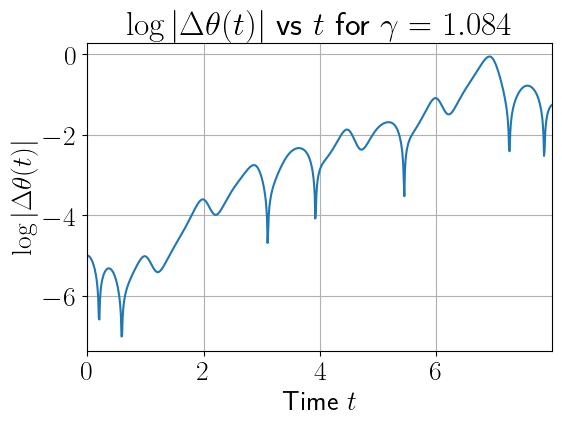

In [25]:
omega   = 2 * np.pi
omega_o = 1.5 * omega
beta    = omega_o / 4
gamma   = 1.084
T       = 2 * np.pi / omega
dt      = 0.01               # Small time step for better accuracy
x0_1    = [0, 0]             # theta(0) = 0, theta_dot(0) = 0
x0_2    = [0.00001, 0]       # theta(0) = 0.00001, theta_dot(0) = 0
t_span  = [0, 8*T]
params  = [beta, omega_o, gamma, omega]
t, sol1 = RK4(damped_driven_pendulum, t_span, params, dt, x0_1)
_, sol2 = RK4(damped_driven_pendulum, t_span, params, dt, x0_2)
theta1  = sol1[:, 0]
theta2  = sol2[:, 0]
dtheta  = abs(theta2 - theta1)

plt.figure(figsize=(6,4))
plt.plot(t, np.log10(dtheta))
plt.xlabel('Time $t$')
plt.ylabel(r'$\log|\Delta\theta(t)|$')
plt.title(r'$\log|\Delta\theta(t)|$ vs $t$ for '+f'$\\gamma={gamma}$')
plt.xlim([t.min(),t.max()])
plt.grid(True)
plt.show()

**12.15** Numerically solve the equation of motion (12.11) for a DDP with the following parameters:                                   
$ \qquad \ $ drive strength $\gamma = 0.3,$                                                                                                                     
$ \qquad \ $ drive frequency $\omega = 2\pi$,                                                                                                             
$ \qquad \ $ natural frequency $\omega_o = 1.5\omega,$                                                                                                           
$ \qquad \ $ damping constant $\displaystyle\beta=\frac{\omega_o}{4},$                                                                                      
$ \qquad \ $ and initial conditions $\phi(0) = \dot{\phi}(0) = 0.$                                                                                                          
$ \qquad \ $ Solve for the first five drive cycles $(0\le t\le 5)$ and call your solution $\phi_1(t)$.                                       
$ \qquad \ $ Solve again for all the same parameters except that $\phi(0) = 1$ (that is, the initial angle is one radian) and call this solution $\phi_2 (t)$ .                                                                                                           
$ \qquad \ $ Let $\Delta\phi(t)=\phi_2(t)-\phi_1(0)$ and make a plot of $\log |\Delta\phi(t)|$ against $t$. Does your plot confirm that $\Delta\phi(t)$ goes to zero exponentially?                                                                                                 
$ \qquad \ $ Note: The exponential decay continues indefinitely, but $\Delta\phi(t)$ eventually gets so small that it is smaller than the rounding errors,                                                                                                                 
$ \qquad \ $ and the exponential decay cannot be seen. If you want to go further, you will probably need to crank up your precision.

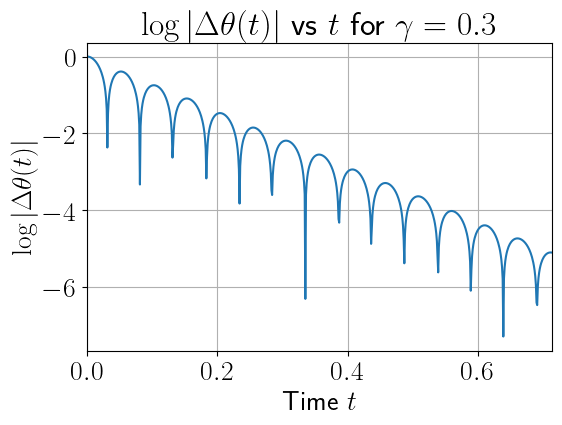

In [24]:
omega   = 2 * np.pi * 7
omega_o = 1.5 * omega
beta    = omega_o / 4
gamma   = 0.3                 # drive strength
T       = 2 * np.pi / omega   # period of driving force
dt      = 0.001               # time step
x0_1    = [0, 0]              # theta(0) = 0, theta_dot(0) = 0
x0_2    = [1, 0]              # theta(0) = 1, theta_dot(0) = 0
t_span  = [0, 5 * T]
params  = [beta, omega_o, gamma, omega]
t, sol1 = RK4(damped_driven_pendulum, t_span, params, dt, x0_1)
_, sol2 = RK4(damped_driven_pendulum, t_span, params, dt, x0_2)
theta1  = sol1[:, 0]
theta2  = sol2[:, 0]
dtheta  = abs(theta2 - theta1)

plt.figure(figsize=(6,4))
plt.plot(t, np.log10(dtheta))
plt.xlabel('Time $t$')
plt.ylabel(r'$\log|\Delta\theta(t)|$')
plt.title(r'$\log|\Delta\theta(t)|$ vs $t$ for '+f'$\\gamma={gamma}$')
plt.xlim([t.min(),t.max()])
plt.grid(True)
plt.show()

**12.16** Consider the chaotic motion of a DDP for which the Liapunov exponent is $\lambda = 1,$ with time measured in units of the drive period as usual.                                                                                                            
$ \qquad \ $  (This is very roughly the value found in Problem 12.13.)                                                      
$ \qquad \ $ (a) Suppose that you need to predict $\phi(t)$ with an accuracy of $1/100 \text{ rad}$ and that you know the initial value $\phi(0)$ within $10^{-6}\text{ rad}$.                                                                                            
$ \qquad \ $  What is the maximum time **$t_{max}$** for which you can predict $\phi(t)$ within the required accuracy?                            
$ \qquad \ $ This **$t_{max}$** is sometimes called the **time horizon** for prediction within a specified accuracy.                         
$ \qquad \ $ (b) Suppose that, with a vast expenditure of money and labor, you manage to improve the accuracy of your initial value to $10^{-9}$ radians.                                                                           
$ \qquad \ $  What is the time horizon now (for the same required accuracy of prediction)? By what factor has **$t_{max}$** improved?                  
$ \qquad \ $ Your results illustrate the difficulty of making accurate long-term predictions for chaotic motion.                                    
              

(a)                                                                                                                                        
$ \quad$ From 12.26,                                                                                                                                                       
$\qquad \begin{align} &{\therefore}\qquad |\Delta\phi(t)| \sim Ke^{\lambda t} \\ &{or,}\qquad \Delta\phi(t) = \Delta\phi(0) e^{\lambda t} \\  &{or,}\quad\frac{\Delta\phi(t)}{\Delta\phi(0)} \ \ = e^{\lambda t} \end{align}$                                                                                                
$ \quad$ Taking $\log$ on both sides,                                                                                                       
$\qquad\begin{align} &{\therefore} \quad\ln\bigg(\frac{\Delta\phi(t)}{\Delta\phi(0)}\bigg) = \ln(e^{\lambda t}) = \lambda t \\ &{or,}  \quad t_{max} = \frac{1}{\lambda}\ln\bigg(\frac{\Delta\phi(t)}{\Delta\phi(0)}\bigg) = 1\times\ln\bigg(\frac{1/100}{10^{-6}}\bigg) = \ln(10^4) = 9.21 \end{align}$                                                            

(b)                                                                                                                                     
$ \quad$ Reducing $\phi(0)=10^{-9}$                                                                                       
$\qquad\begin{align} t_{max} = \frac{1}{\lambda}\ln\bigg(\frac{\Delta\phi(t)}{\Delta\phi(0)}\bigg) = 1\times\ln\bigg(\frac{1/100}{10^{-9}}\bigg) = \ln(10^7) = 16.1 \end{align}$ 

**12.17** In Figure 12.15, you can see that for $\gamma = 1.503$ the DDP "tries" to execute a steady rolling motion changing by $2\pi$ once each cycle,                                                                                                      
but that there is superposed an erratic wobbling and that the direction of the rolling reverses itself from time to time.     
For other values of $\gamma$, the pendulum actually does approach a steady, periodic rolling.                                        
(a) Solve the equation of motion (12.11) for a drive strength $\gamma = 1.3$ and all other parameters as in the first part of Problem 12.14, for $0\le t\le 8.$                                                                                                   
$ \ \ \ \ $ Call your solution $\phi_1(t)$ and plot it as a function of $t$. Describe the motion.                                             
(b) It is hard to be sure that the motion is periodic based on this graph, because of the steady rolling through $-2\pi$ each cycle.                                                                                                                                                     
$ \ \ \ \ $ As a better check, plot $\phi_1 (t) + 2\pi t$ against time. Describe what this shows. This kind of periodic rolling motion is sometimes described as **phase-locked**.

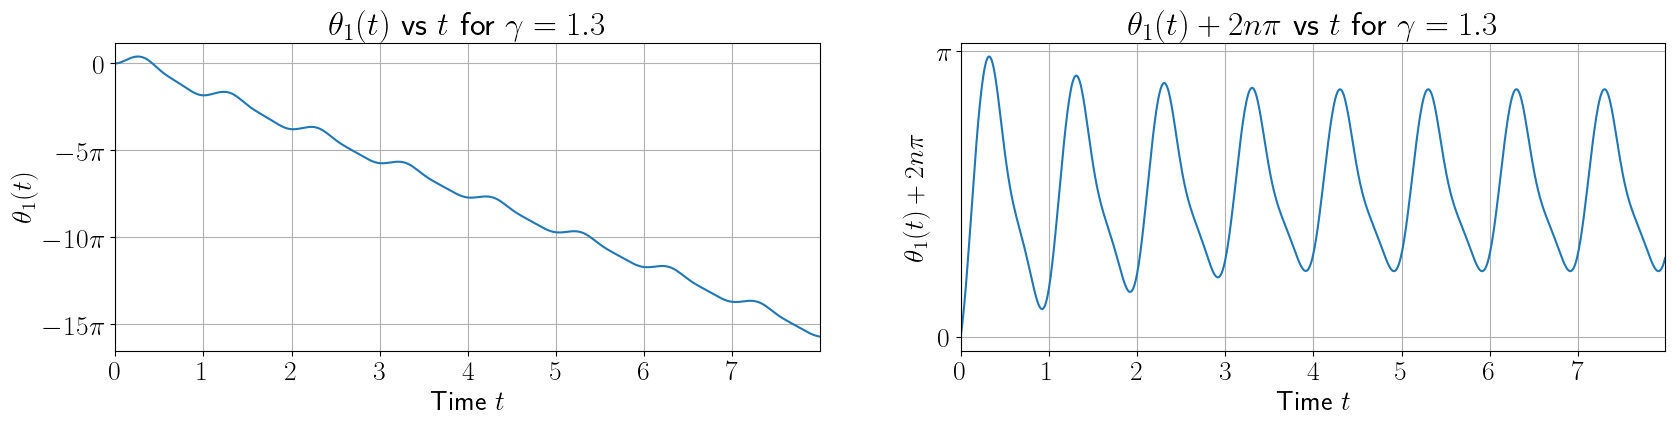

In [17]:
theta0     = 0.0              # initial angle
theta_dot0 = 0.0              # initial angular velocity
t_span     = [0, 8]
omega      = 2 * np.pi 
omega_o    = 1.5 * omega
beta       = omega_o / 4
gamma      = 1.3              # drive strength
dt         = 0.01             # time step
x0         = [0, 0]           # theta(0) = 0, theta_dot(0) = 0
t_span     = [0, 8]           # 0 < t < 8
params     = [beta, omega_o, gamma, omega]
t, sol     = RK4(damped_driven_pendulum, t_span, params, dt, x0)
theta1     = sol[:, 0]
n_values   = np.arange(-10, 11, 2)

fig, ax = plt.subplots(1,2, figsize=(20, 4))
ax[0].plot(t, theta1)   
ax[0].set_xlabel('Time $t$')
ax[0].set_ylabel(r'$\theta_1(t)$')
ax[0].set_title(r'$\theta_1(t)$ vs $t$ for '+f'$\\gamma={gamma}$')
ax[0].set_yticks([-15*np.pi,-10*np.pi,-5*np.pi,0], [r'$-15\pi$',r'$-10\pi$',r'$-5\pi$',r'$0$'])
ax[0].set_xlim([t.min(),t.max()])
ax[0].grid(True)

ax[1].plot(t, theta1 + 2 * np.pi * t)  
ax[1].set_xlabel('Time $t$')
ax[1].set_ylabel(r'$\theta_1(t) + 2n\pi$')
ax[1].set_title(r'$\theta_1(t) + 2n\pi$ vs $t$ for '+f'$\\gamma={gamma}$')
ax[1].set_xlim([t.min(),t.max()])
ax[1].grid(True)
ax[1].set_yticks([0,np.pi],[r'$0$',r'$\pi$'])
plt.show()

**12.18** Since the rolling motion of Problem 12.17 is periodic (and hence not chaotic) we would expect the difference $\Delta\phi(t)$ between neighboring solutions                                                                                    
$ \qquad \ $ (solutions of the same equation, but with slightly different initial conditions) to decrease exponentially.                       
$ \qquad \ $ To illustrate this, do part (a) of Problem 12.17 and then find the solution of the same problem except that $\phi(0) = 1$.   
$ \qquad \ $ Call this second solution $\phi_2(0)$ and let $\Delta\phi(t)= \phi_2(t) - \phi_1(t)$. Make a plot of $\log|\Delta\phi(t)|$ against $t$ and comment.

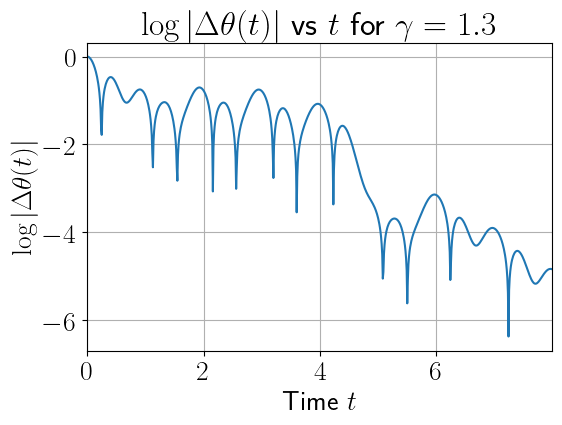

In [23]:
omega   = 2 * np.pi 
omega_o = 1.5 * omega
beta    = omega_o / 4
gamma   = 1.3   # drive strength
dt      = 0.01  # time step
params  = [beta, omega_o, gamma, omega]
t_span  = [0, 8]  # 0 < t < 8
x0_1    = [0, 0]               # theta(0) = 0, theta_dot(0) = 0
x0_2    = [1, 0]               # theta(0) = 1, theta_dot(0) = 0
t, sol1 = RK4(damped_driven_pendulum, t_span, params, dt, x0_1)
_, sol2 = RK4(damped_driven_pendulum, t_span, params, dt, x0_2)
theta1  = sol1[:, 0]
theta2  = sol2[:, 0]
dtheta  = abs(theta2 - theta1)

plt.figure(figsize=(6,4))
plt.plot(t, np.log10(dtheta))
plt.xlabel('Time $t$')
plt.ylabel(r'$\log|\Delta \theta(t)|$')
plt.title(r'$\log|\Delta \theta(t)|$ vs $t$ for '+f'$\\gamma={gamma}$')
plt.xlim([t.min(),t.max()])
plt.grid(True)
plt.show()

#### Deep study of DPP in Phase-Plot and Poincare Section 

Solve the equation of **Damped Driven Pendulum** numerically, for a large time period with the following parameters :                                
$ \qquad \ $  drive strength $\gamma = 1.5,$                                                                                                            
$ \qquad \ $  drive frequency $\omega = 2\pi ,$                                                                                                            
$ \qquad \ $  natural frequency $\omega_o = 1.5\omega ,$                                                                                              
$ \qquad \ $  damping constant $\displaystyle\beta=\frac{\omega_o}{8},$                                                                               
$ \qquad \ $  initial conditions $\phi(0)=\dot{\phi}(0)=0$                                                                                                                                   
Show that the state-space has an chaotic appearance for $10\le t\le 200,$ and interpret it in terms of the pendulum’s motion.                       
And verify that you get the result shown in Figure 12.27

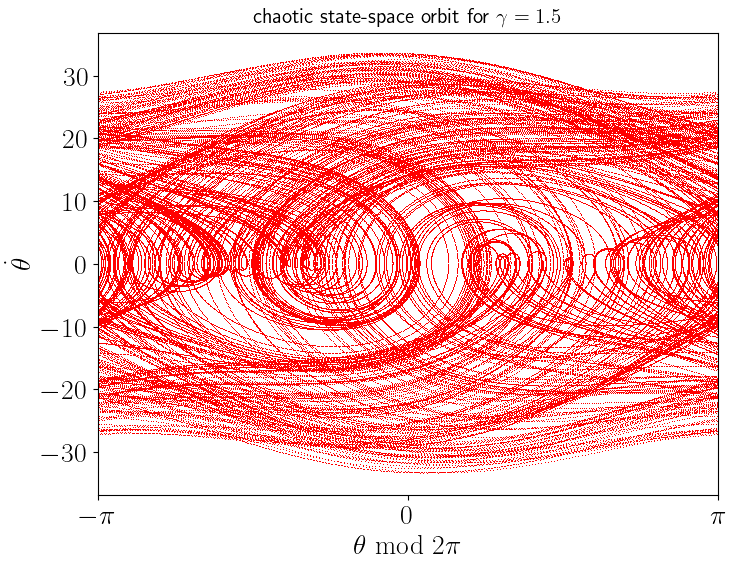

In [19]:
omega   = 2 * np.pi                     # Frequency of the driving force
omega_o = 1.5 * omega                   # Natural frequency
beta    = omega_o / 8                   # Damping coefficient
gamma   = 1.5                           # Amplitude of the driving force
init_x0 = [0, 0]                        # Initial conditions [theta0, theta_dot0]
dt      = 0.001                         # Time step
t_span  = [0, 200]                      # Time span 
params  = [beta, omega_o, gamma, omega]
t, soln = RK4(damped_driven_pendulum, t_span, params, dt, init_x0)
theta_chaotic, theta_dot_chaotic = soln[:, 0], soln[:, 1]
chaotic_x = (theta_chaotic - np.pi) % (2*np.pi) - np.pi

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(chaotic_x[int(10/dt):int(190/dt)], theta_dot_chaotic[int(10/dt):int(190/dt)], 'r,', ms=0.6)
ax.set_xlim(chaotic_x.min(), chaotic_x.max())
ax.set_xticks([-np.pi, 0, np.pi], [r'$-\pi$',r'$0$',r'$\pi$'])
ax.set_title(f'chaotic state-space orbit for $\\gamma={gamma}$', fontsize=15)
ax.set_xlabel(r'$\theta \ \mathrm{ mod } \ 2\pi$')
ax.set_ylabel(r'$\dot{\theta}$')
plt.show()

Solve the equation of **Damped Driven Pendulum** numerically, for a large time period with the following parameters :                                
$ \qquad \ $  drive strength $\gamma = 1.5,$                                                                                                                
$ \qquad \ $  drive frequency $\omega = 2\pi ,$                                                                                                              
$ \qquad \ $  natural frequency $\omega_o = 1.5\omega ,$                                                                                                    
$ \qquad \ $  damping constant $\displaystyle\beta=\frac{\omega_o}{8},$                                                                                    
$ \qquad \ $  initial conditions $\phi(0)=\dot{\phi}(0)=0$                                                                                                                  
Plot the Poincaré section  by strobing the system whenever $t=2\pi k,$ where $k$ is an integer and verify that you get the result shown in Figure 12.29                                      

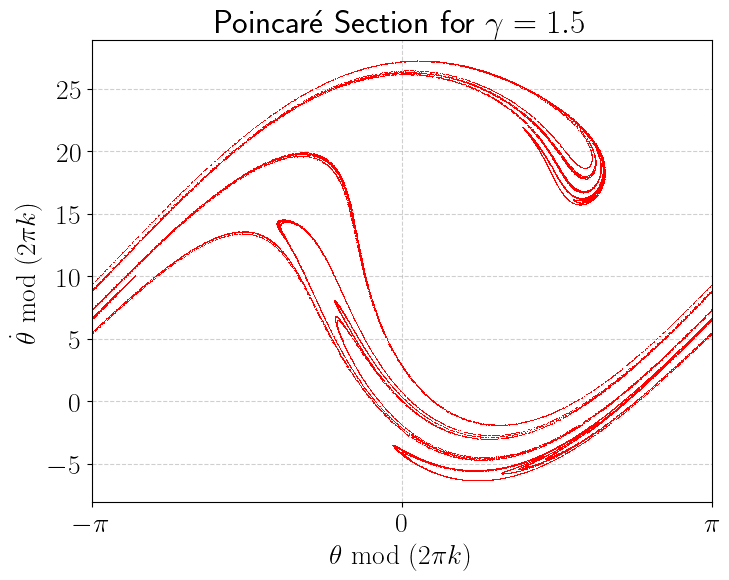

In [20]:
omega   = 2 * np.pi                     # Frequency of the driving force
omega_o = 1.5 * omega                   # Natural frequency
beta    = omega_o / 8                   # Damping coefficient
gamma   = 1.5                           # Amplitude of the driving force
x0      = [0, 0]                        # Initial conditions [theta0, theta_dot0]
dt      = 0.001                         # Time step
t_span  = [0, 60000]                    # Time span
params  = [beta, omega_o, gamma, omega]
Tau     = 2 * np.pi / omega
t, soln = RK4(damped_driven_pendulum, t_span, params, dt, x0)
theta, theta_dot   = soln[:, 0], soln[:, 1]
indices            = (t / Tau % 1 < dt / Tau)
strobing_theta     = theta[indices]
strobing_theta_dot = theta_dot[indices]
poincare_x         = (strobing_theta - np.pi) % (2 * np.pi) - np.pi

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(poincare_x[int(10/dt):], strobing_theta_dot[int(10/dt):], 'r,', ms=0.6)
ax.set_xlim(poincare_x.min(), poincare_x.max())
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r'$-\pi$', r'$0$', r'$\pi$'])
ax.set_title(f'Poincaré Section for $\\gamma={gamma}$')
ax.set_xlabel(r'$ \theta \ \mathrm{ mod } \ (2\pi k) $')
ax.set_ylabel(r'$ \dot{\theta} \ \mathrm{ mod } \ (2\pi k)$')
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()

Solve the equation of **Damped Driven Pendulum** numerically, for a large time period with the following parameters :                                
$ \qquad \ $  drive strength $\gamma = 1.5,$                                                                                                                      
$ \qquad \ $  drive frequency $\omega = 2\pi ,$                                                                                                               
$ \qquad \ $  natural frequency $\omega_o = 1.5\omega ,$                                                                                                      
$ \qquad \ $  damping constant $\displaystyle\beta=\frac{\omega_o}{8},$                                                                                      
$ \qquad \ $  initial conditions $\phi(0)=\dot{\phi}(0)=0$                         

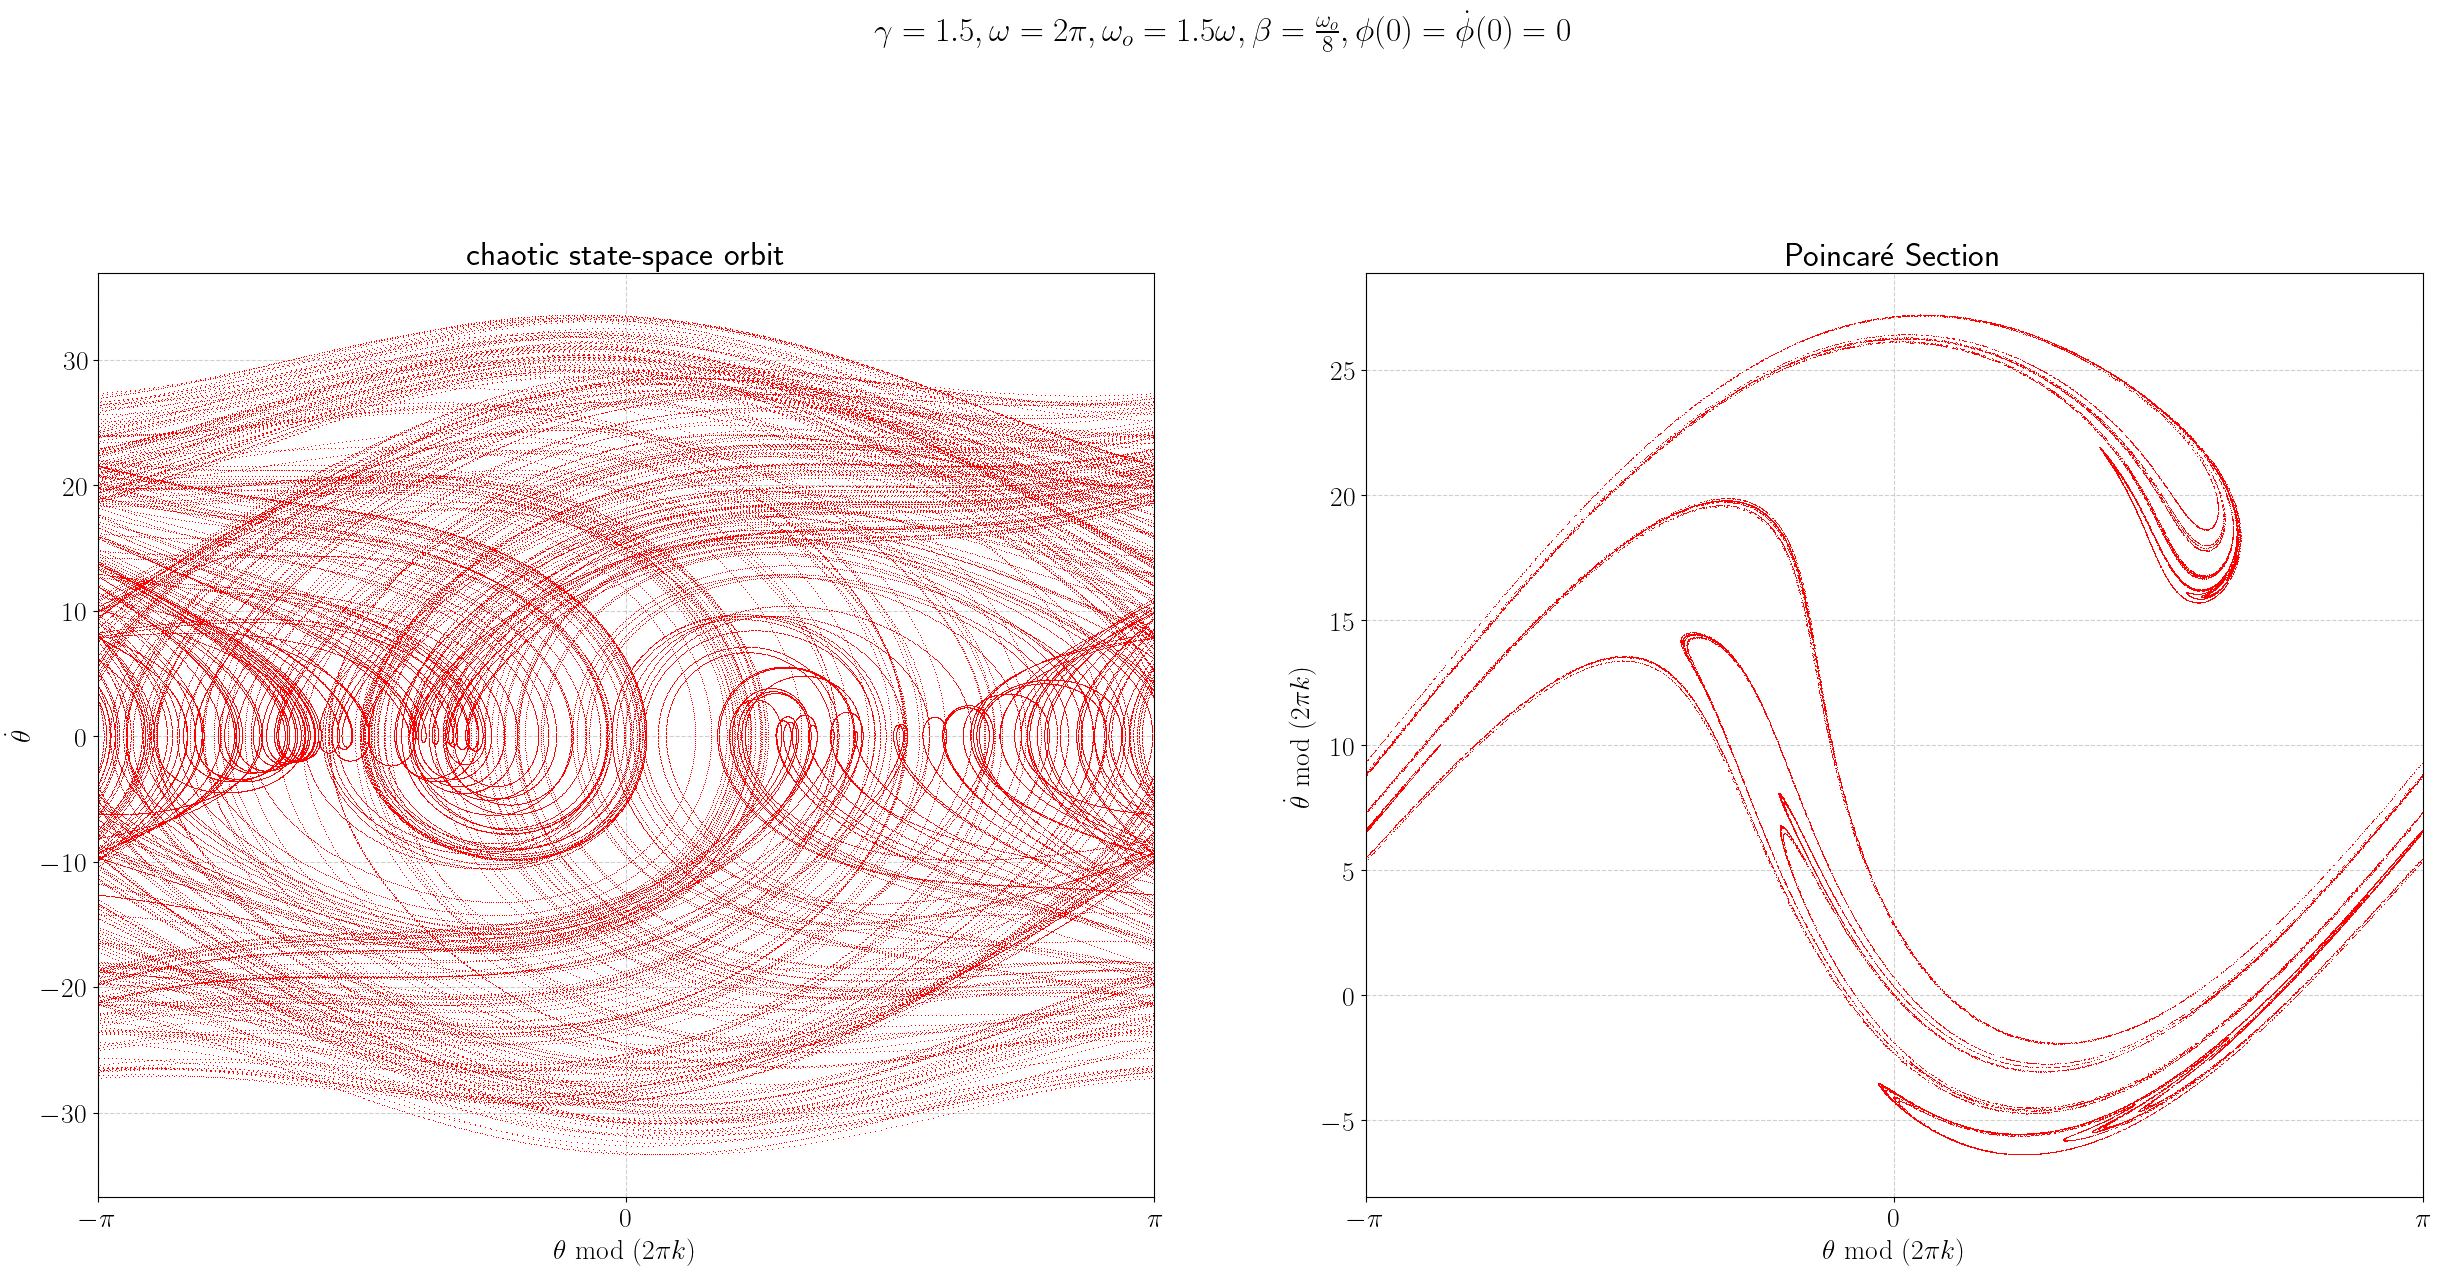

In [22]:
omega   = 2 * np.pi                     # Frequency of the driving force
omega_o = 1.5 * omega                   # Natural frequency
beta    = omega_o / 8                   # Damping coefficient
gamma   = 1.5                           # Amplitude of the driving force
init_x0 = [0, 0]                        # Initial conditions [theta0, theta_dot0]
dt      = 0.001                         # Time step
t_span  = [0, 60000]                    # Time span                 
params  = [beta, omega_o, gamma, omega]
Tau     = 2 * np.pi / omega
t, soln = RK4(damped_driven_pendulum, t_span, params, dt, init_x0)
theta, theta_dot   = soln[:, 0], soln[:, 1]
chaotic_x          = (theta - np.pi) % (2*np.pi) - np.pi
indices            = (t / Tau % 1 < dt / Tau)
strobing_theta     = theta[indices]
strobing_theta_dot = theta_dot[indices]
poincare_x         = (strobing_theta - np.pi) % (2 * np.pi) - np.pi

fig, ax = plt.subplots(1,2,figsize=(30,12))
fig.suptitle(r'$ \gamma = 1.5,\omega = 2\pi,\omega_o=1.5\omega,\beta=\frac{\omega_o}{8},\phi(0)=\dot{\phi}(0)=0 $',y=1.1)
ax[0].plot(chaotic_x[int(10/dt):int(190/dt)], theta_dot[int(10/dt):int(190/dt)], 'r,' )
ax[0].set_title(f'chaotic state-space orbit')
ax[0].set_xlabel(r'$ \theta \ \mathrm{ mod } \ (2\pi k) $')
ax[0].set_ylabel(r'$ \dot{\theta} $')
ax[0].set_xlim(chaotic_x.min(), chaotic_x.max())
ax[0].set_xticks([-np.pi, 0, np.pi],[r'$-\pi$', r'$0$', r'$\pi$'])
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].plot(poincare_x[int(10/dt):], strobing_theta_dot[int(10/dt):], 'r,', ms=0.6)
ax[1].set_xlim(poincare_x.min(), poincare_x.max())
ax[1].set_xticks([-np.pi, 0, np.pi],[r'$-\pi$', r'$0$', r'$\pi$'])
ax[1].set_title(f'Poincaré Section ')
ax[1].set_xlabel(r'$ \theta \ \mathrm{ mod } \ (2\pi k) $')
ax[1].set_ylabel(r'$ \dot{\theta} \ \mathrm{ mod } \ (2\pi k)$')
ax[1].grid(True, linestyle='--', alpha=0.6)
plt.show()

Solve the equation of **Damped Driven Pendulum** numerically, for a large time period with the following parameters :                                
$ \qquad \ $  drive strength $\gamma = 2.7,$                                                                                                                 
$ \qquad \ $  drive frequency $\omega = 1 ,$                                                                                                                     
$ \qquad \ $  natural frequency $\omega_o = \omega ,$                                                                                                        
$ \qquad \ $  damping constant $\displaystyle\beta=0.11,$                                                                                                     
$ \qquad \ $  initial conditions $\phi(0)=\dot{\phi}(0)=0$                         

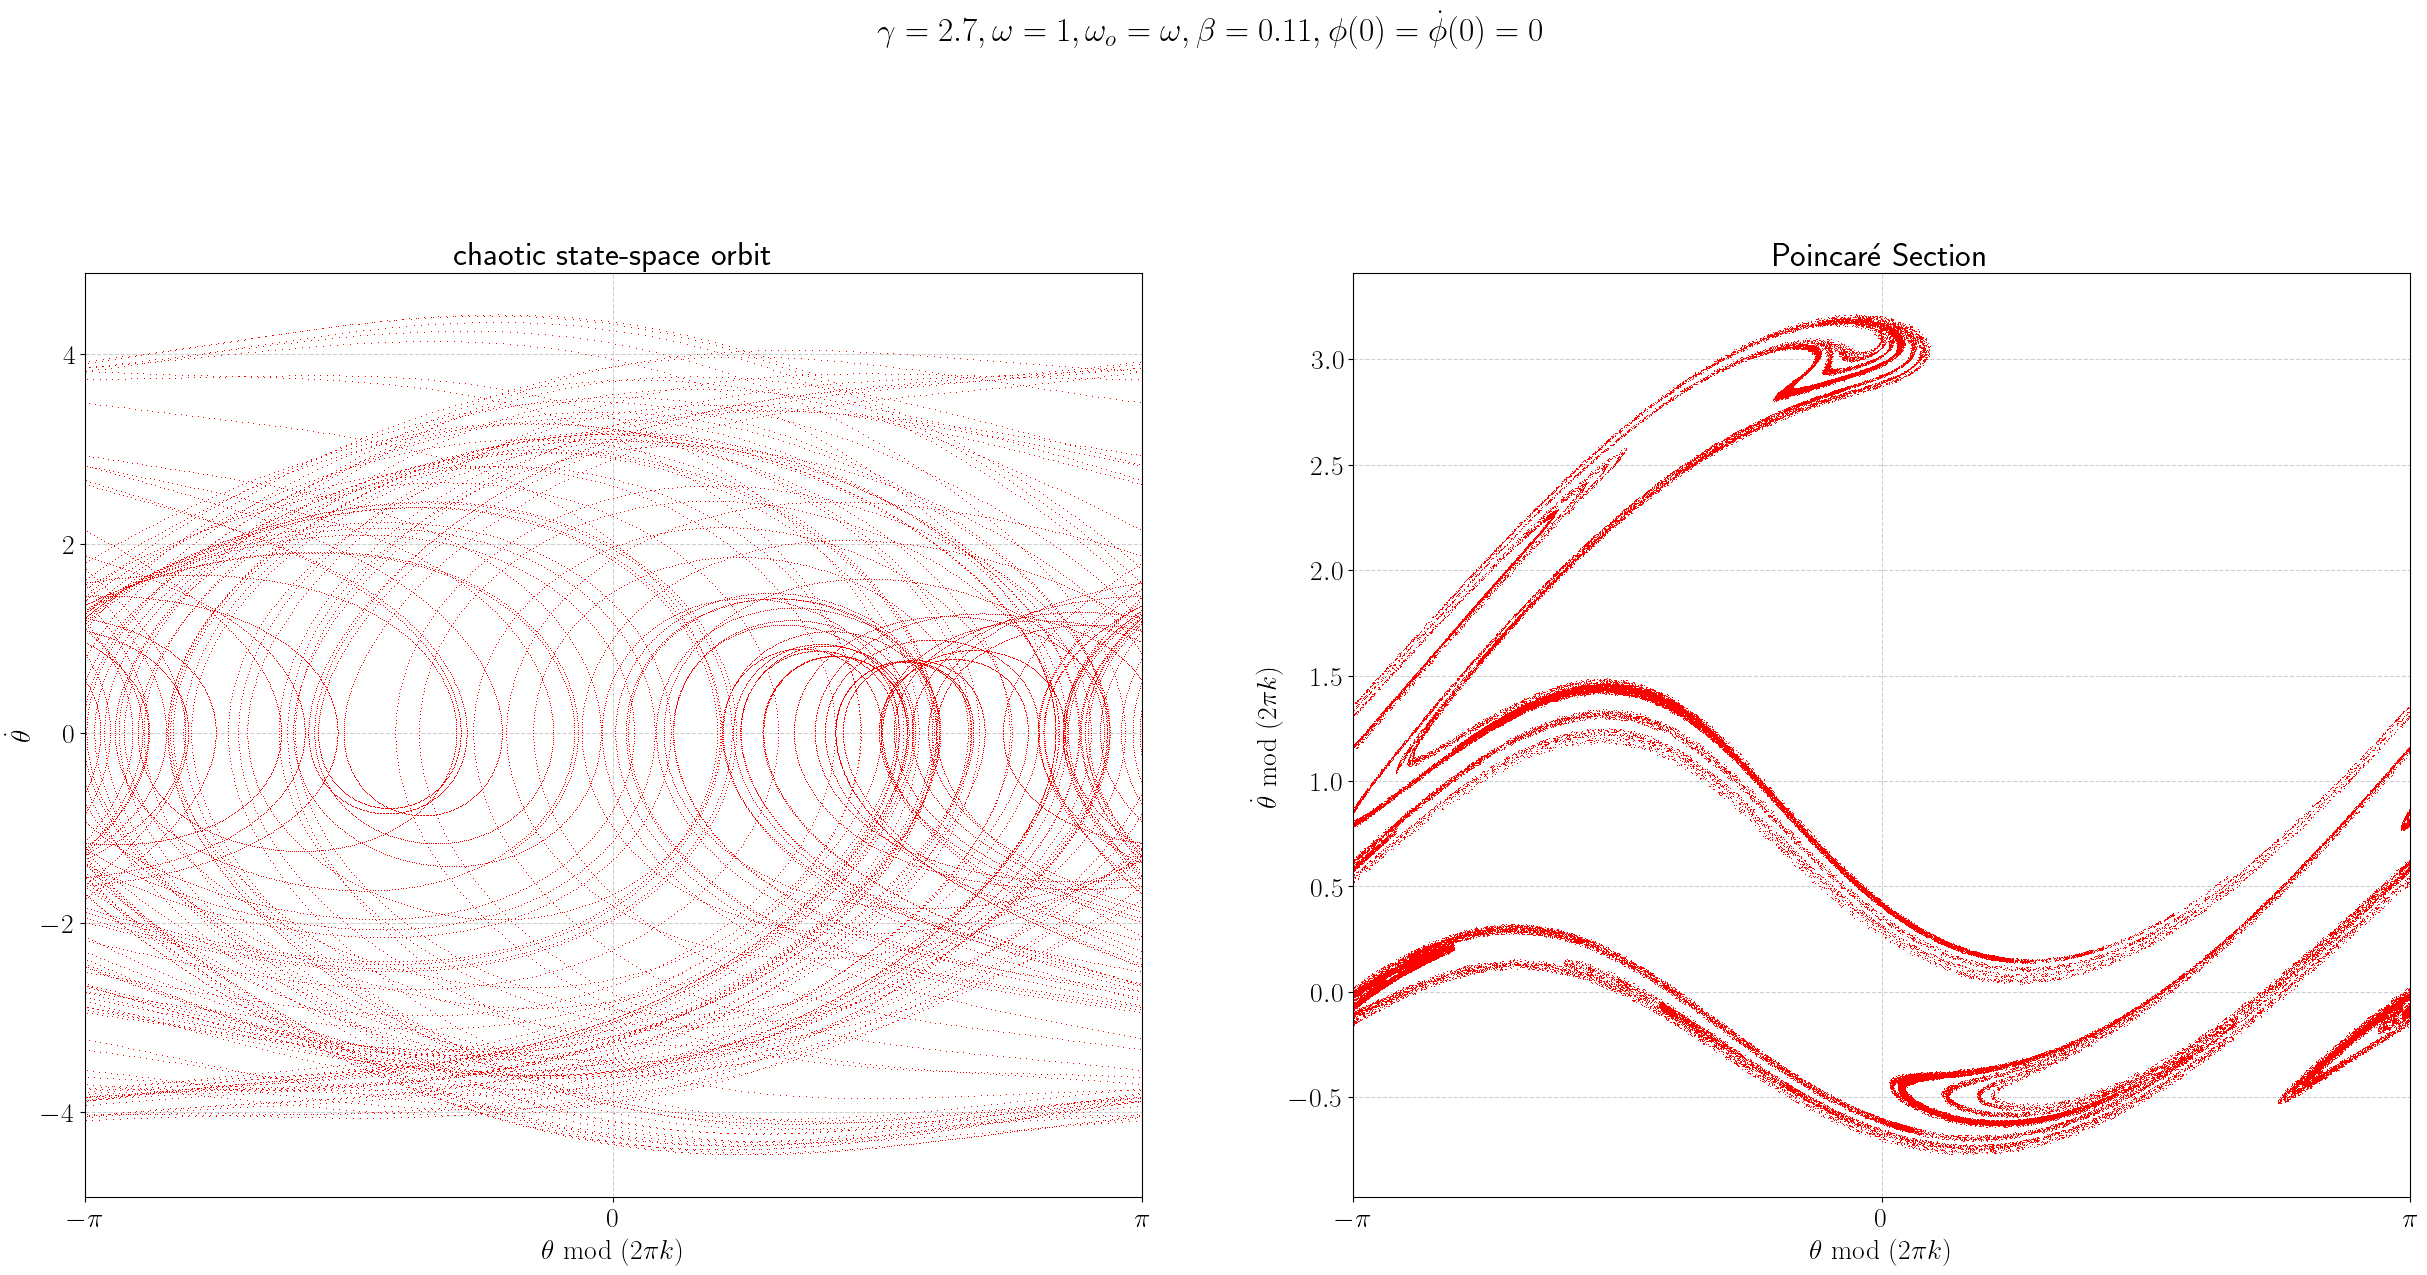

In [23]:
omega   = 1                               # Frequency of the driving force
omega_o = omega                           # Natural frequency
beta    = 0.11                            # Damping coefficient
gamma   = 2.7                             # Amplitude of the driving force
x0      = [0, 0]                          # Initial conditions [theta0, theta_dot0]
dt      = 0.01                            # Time step
t_span  = [0, 800000]                     # Time span
params  = [beta, omega_o, gamma, omega]
Tau     = 2 * np.pi / omega
t, soln = RK4(damped_driven_pendulum, t_span, params, dt, x0)
theta, theta_dot   = soln[:, 0], soln[:, 1]
chaotic_x          = (theta - np.pi) % (2*np.pi) - np.pi
indices            = (t / Tau % 1 < dt / Tau)
strobing_theta     = theta[indices]
strobing_theta_dot = theta_dot[indices]
poincare_x         = (strobing_theta - np.pi) % (2 * np.pi) - np.pi

fig, ax = plt.subplots(1,2,figsize=(30,12))
fig.suptitle(r'$ \gamma = 2.7,\omega = 1 ,\omega_o = \omega ,\beta=0.11,\phi(0)=\dot{\phi}(0)=0 $',y=1.1)
ax[0].plot(chaotic_x[int(10/dt):int(500/dt)], theta_dot[int(10/dt):int(500/dt)], 'r,' )
ax[0].set_title(f'chaotic state-space orbit')
ax[0].set_xlabel(r'$ \theta \ \mathrm{ mod } \ (2\pi k) $')
ax[0].set_ylabel(r'$ \dot{\theta} $')
ax[0].set_xlim(chaotic_x.min(), chaotic_x.max())
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].set_xticks([-np.pi, 0, np.pi],[r'$-\pi$', r'$0$', r'$\pi$'])
ax[1].plot(poincare_x[int(10/dt):], strobing_theta_dot[int(10/dt):], 'r,', ms=0.6)
ax[1].set_xlim(poincare_x.min(), poincare_x.max())
ax[1].set_xticks([-np.pi, 0, np.pi],[r'$-\pi$', r'$0$', r'$\pi$'])
ax[1].set_title(f'Poincaré Section ')
ax[1].set_xlabel(r'$ \theta \ \mathrm{ mod } \ (2\pi k) $')
ax[1].set_ylabel(r'$ \dot{\theta} \ \mathrm{ mod } \ (2\pi k)$')
ax[1].grid(True, linestyle='--', alpha=0.6)
plt.show()

Solve the equation of **Damped Driven Pendulum** numerically, for a large time period with the following parameters :                                
$ \qquad \ $  drive strength $\gamma = 0.75,$                                                                                                                 
$ \qquad \ $  drive frequency $\omega = 0.65 ,$                                                                                                             
$ \qquad \ $  natural frequency $\omega_o = 1 ,$                                                                                                             
$ \qquad \ $  damping constant $\displaystyle\beta=\frac{1}{\sqrt{60}},$                                                                                   
$ \qquad \ $  initial conditions $\phi(0)=\dot{\phi}(0)=0$                         

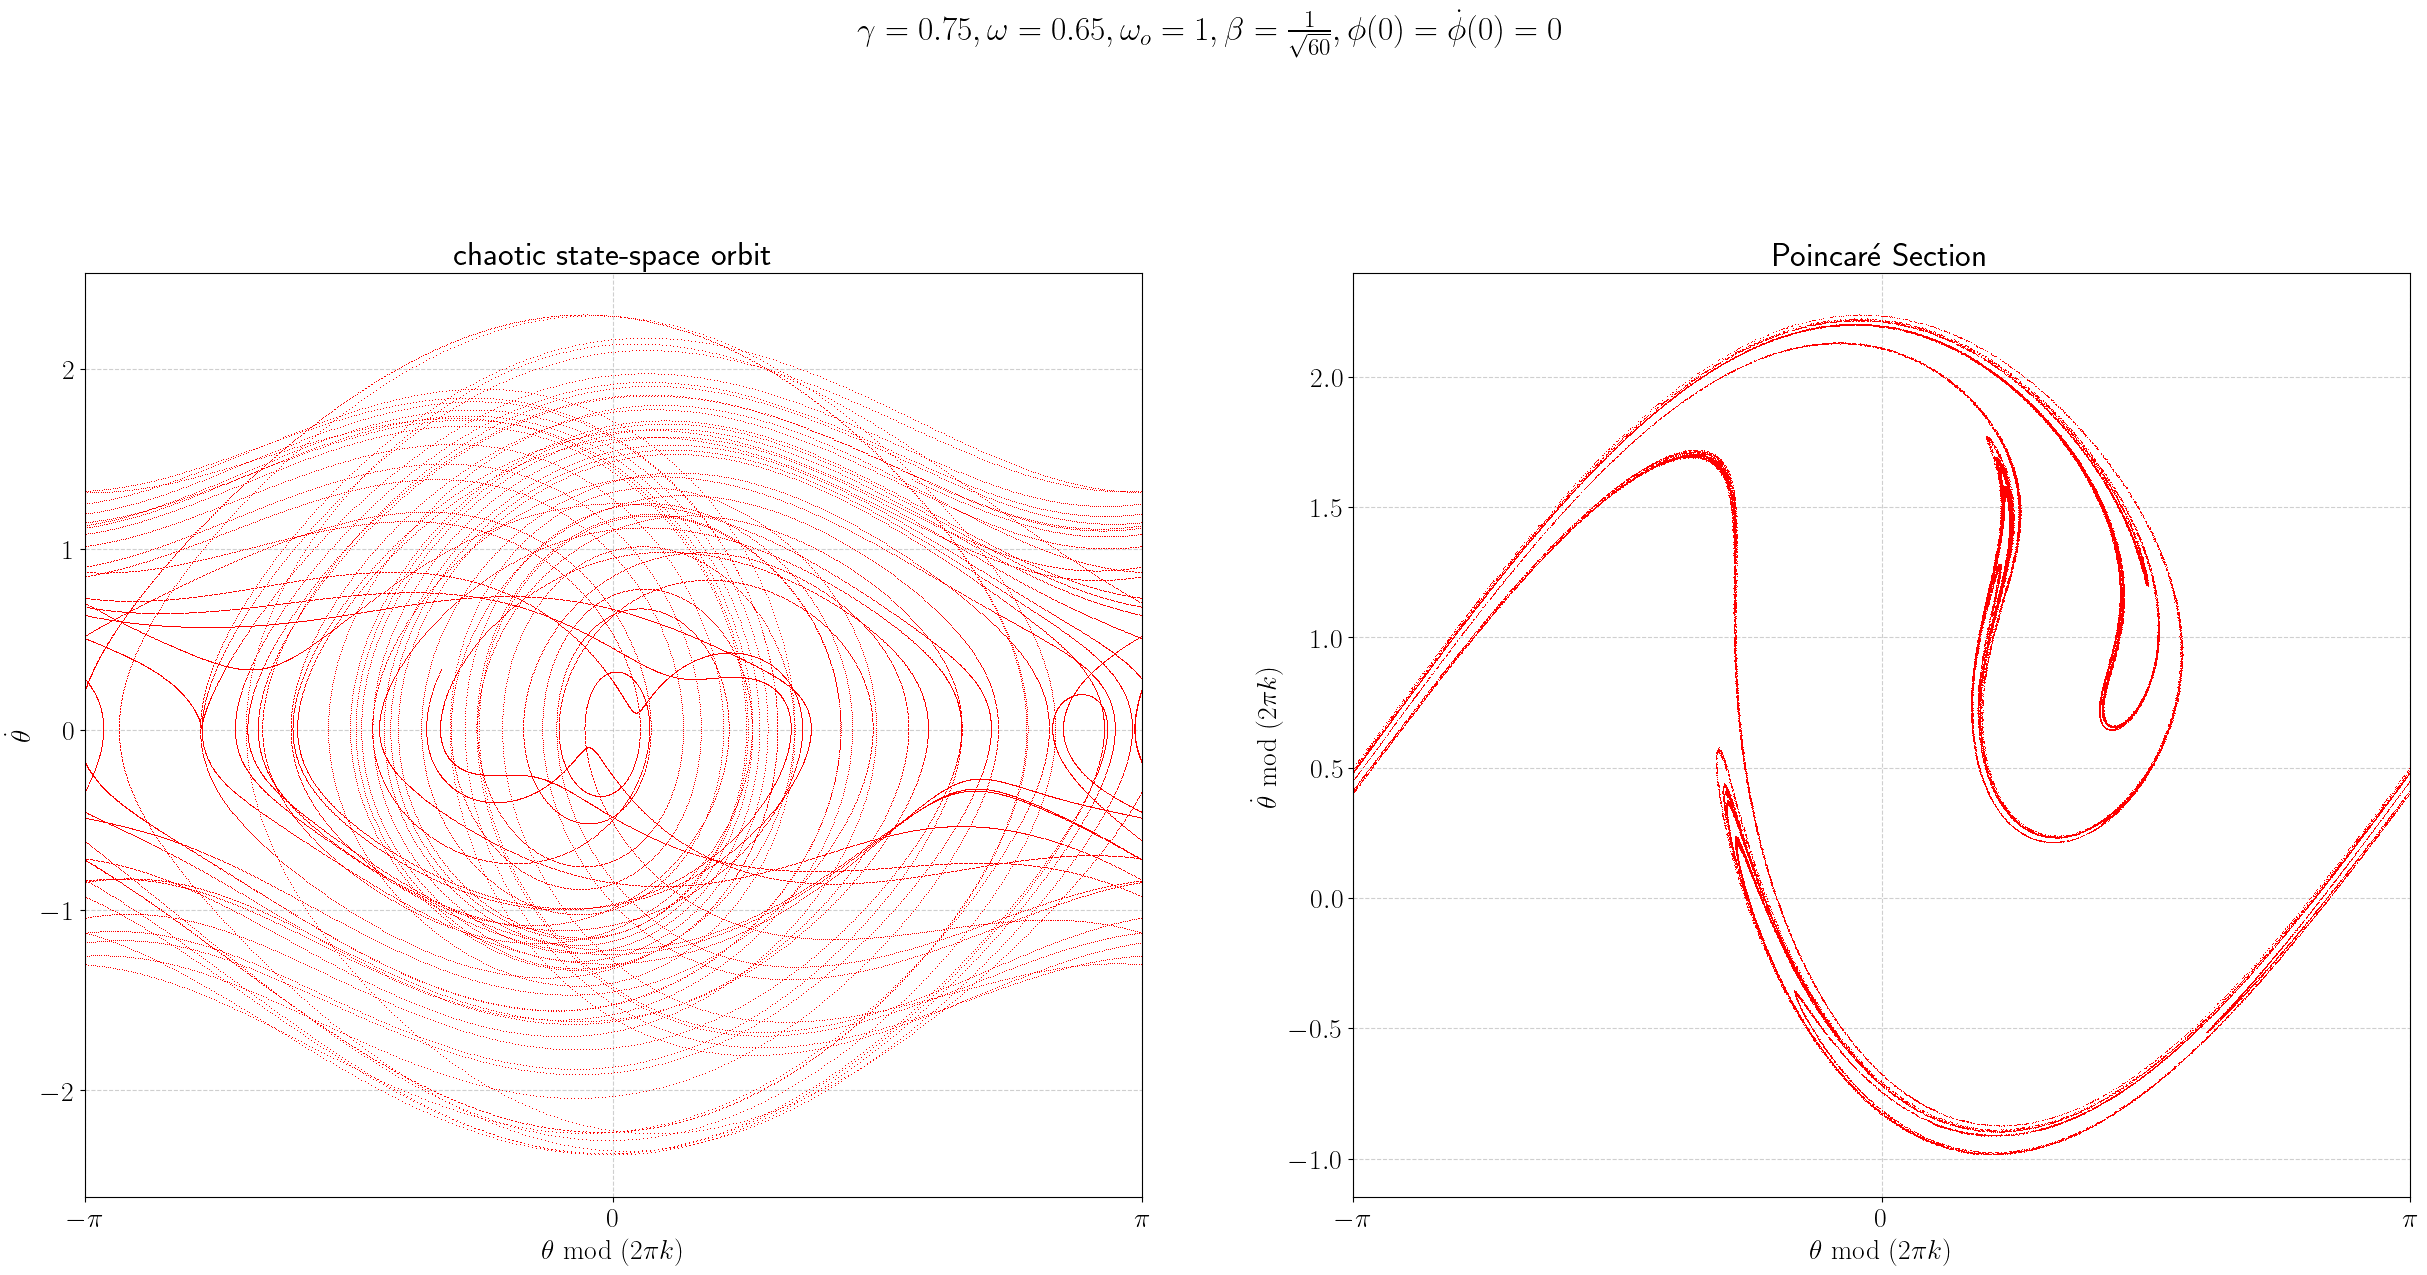

In [24]:
omega   = 0.65                             # Frequency of the driving force
omega_o = 1                                # Natural frequency
beta    = 1/(60)**0.5                      # Damping coefficient
gamma   = 0.75                             # Amplitude of the driving force
x0      = [0, 0]                           # Initial conditions [theta0, theta_dot0]
dt      = 0.01                             # Time step
t_span  = [0, 800000]                      # Time span
params  = [beta, omega_o, gamma, omega]
Tau     = 2 * np.pi / omega
t, soln = RK4(damped_driven_pendulum, t_span, params, dt, x0)
theta, theta_dot   = soln[:, 0], soln[:, 1]
chaotic_x          = (theta - np.pi) % (2*np.pi) - np.pi
indices            = (t / Tau % 1 < dt / Tau)
strobing_theta     = theta[indices]
strobing_theta_dot = theta_dot[indices]
poincare_x         = (strobing_theta - np.pi) % (2 * np.pi) - np.pi

fig, ax = plt.subplots(1,2,figsize=(30,12))
fig.suptitle(r'$ \gamma = 0.75,\omega = 0.65 ,\omega_o = 1 ,\beta=\frac{1}{\sqrt{60}},\phi(0)=\dot{\phi}(0)=0 $',y=1.1)
ax[0].plot(chaotic_x[int(10/dt):int(500/dt)], theta_dot[int(10/dt):int(500/dt)], 'r,' )
ax[0].set_title(f'chaotic state-space orbit')
ax[0].set_xlabel(r'$ \theta \ \mathrm{ mod } \ (2\pi k) $')
ax[0].set_ylabel(r'$ \dot{\theta} $')
ax[0].set_xlim(chaotic_x.min(), chaotic_x.max())
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].set_xticks([-np.pi, 0, np.pi],[r'$-\pi$', r'$0$', r'$\pi$'])
ax[1].plot(poincare_x[int(10/dt):], strobing_theta_dot[int(10/dt):], 'r,', ms=0.6)
ax[1].set_xlim(poincare_x.min(), poincare_x.max())
ax[1].set_xticks([-np.pi, 0, np.pi],[r'$-\pi$', r'$0$', r'$\pi$'])
ax[1].set_title(f'Poincaré Section ')
ax[1].set_xlabel(r'$ \theta \ \mathrm{ mod } \ (2\pi k) $')
ax[1].set_ylabel(r'$ \dot{\theta} \ \mathrm{ mod } \ (2\pi k)$')
ax[1].grid(True, linestyle='--', alpha=0.6)
plt.show()

Solve the equation of **Damped Driven Pendulum** numerically, for a large time period with the following parameters :                                
$ \qquad \ $  drive strength $\gamma = 0.7,$                                                                                                             
$ \qquad \ $  drive frequency $\omega = 0.7 ,$                                                                                                                    
$ \qquad \ $  natural frequency $\omega_o = 1 ,$                                                                                                                
$ \qquad \ $  damping constant $\displaystyle\beta=0.025,$                                                                                                    
$ \qquad \ $  initial conditions $\phi(0)=\dot{\phi}(0)=0$                                                                                                                      

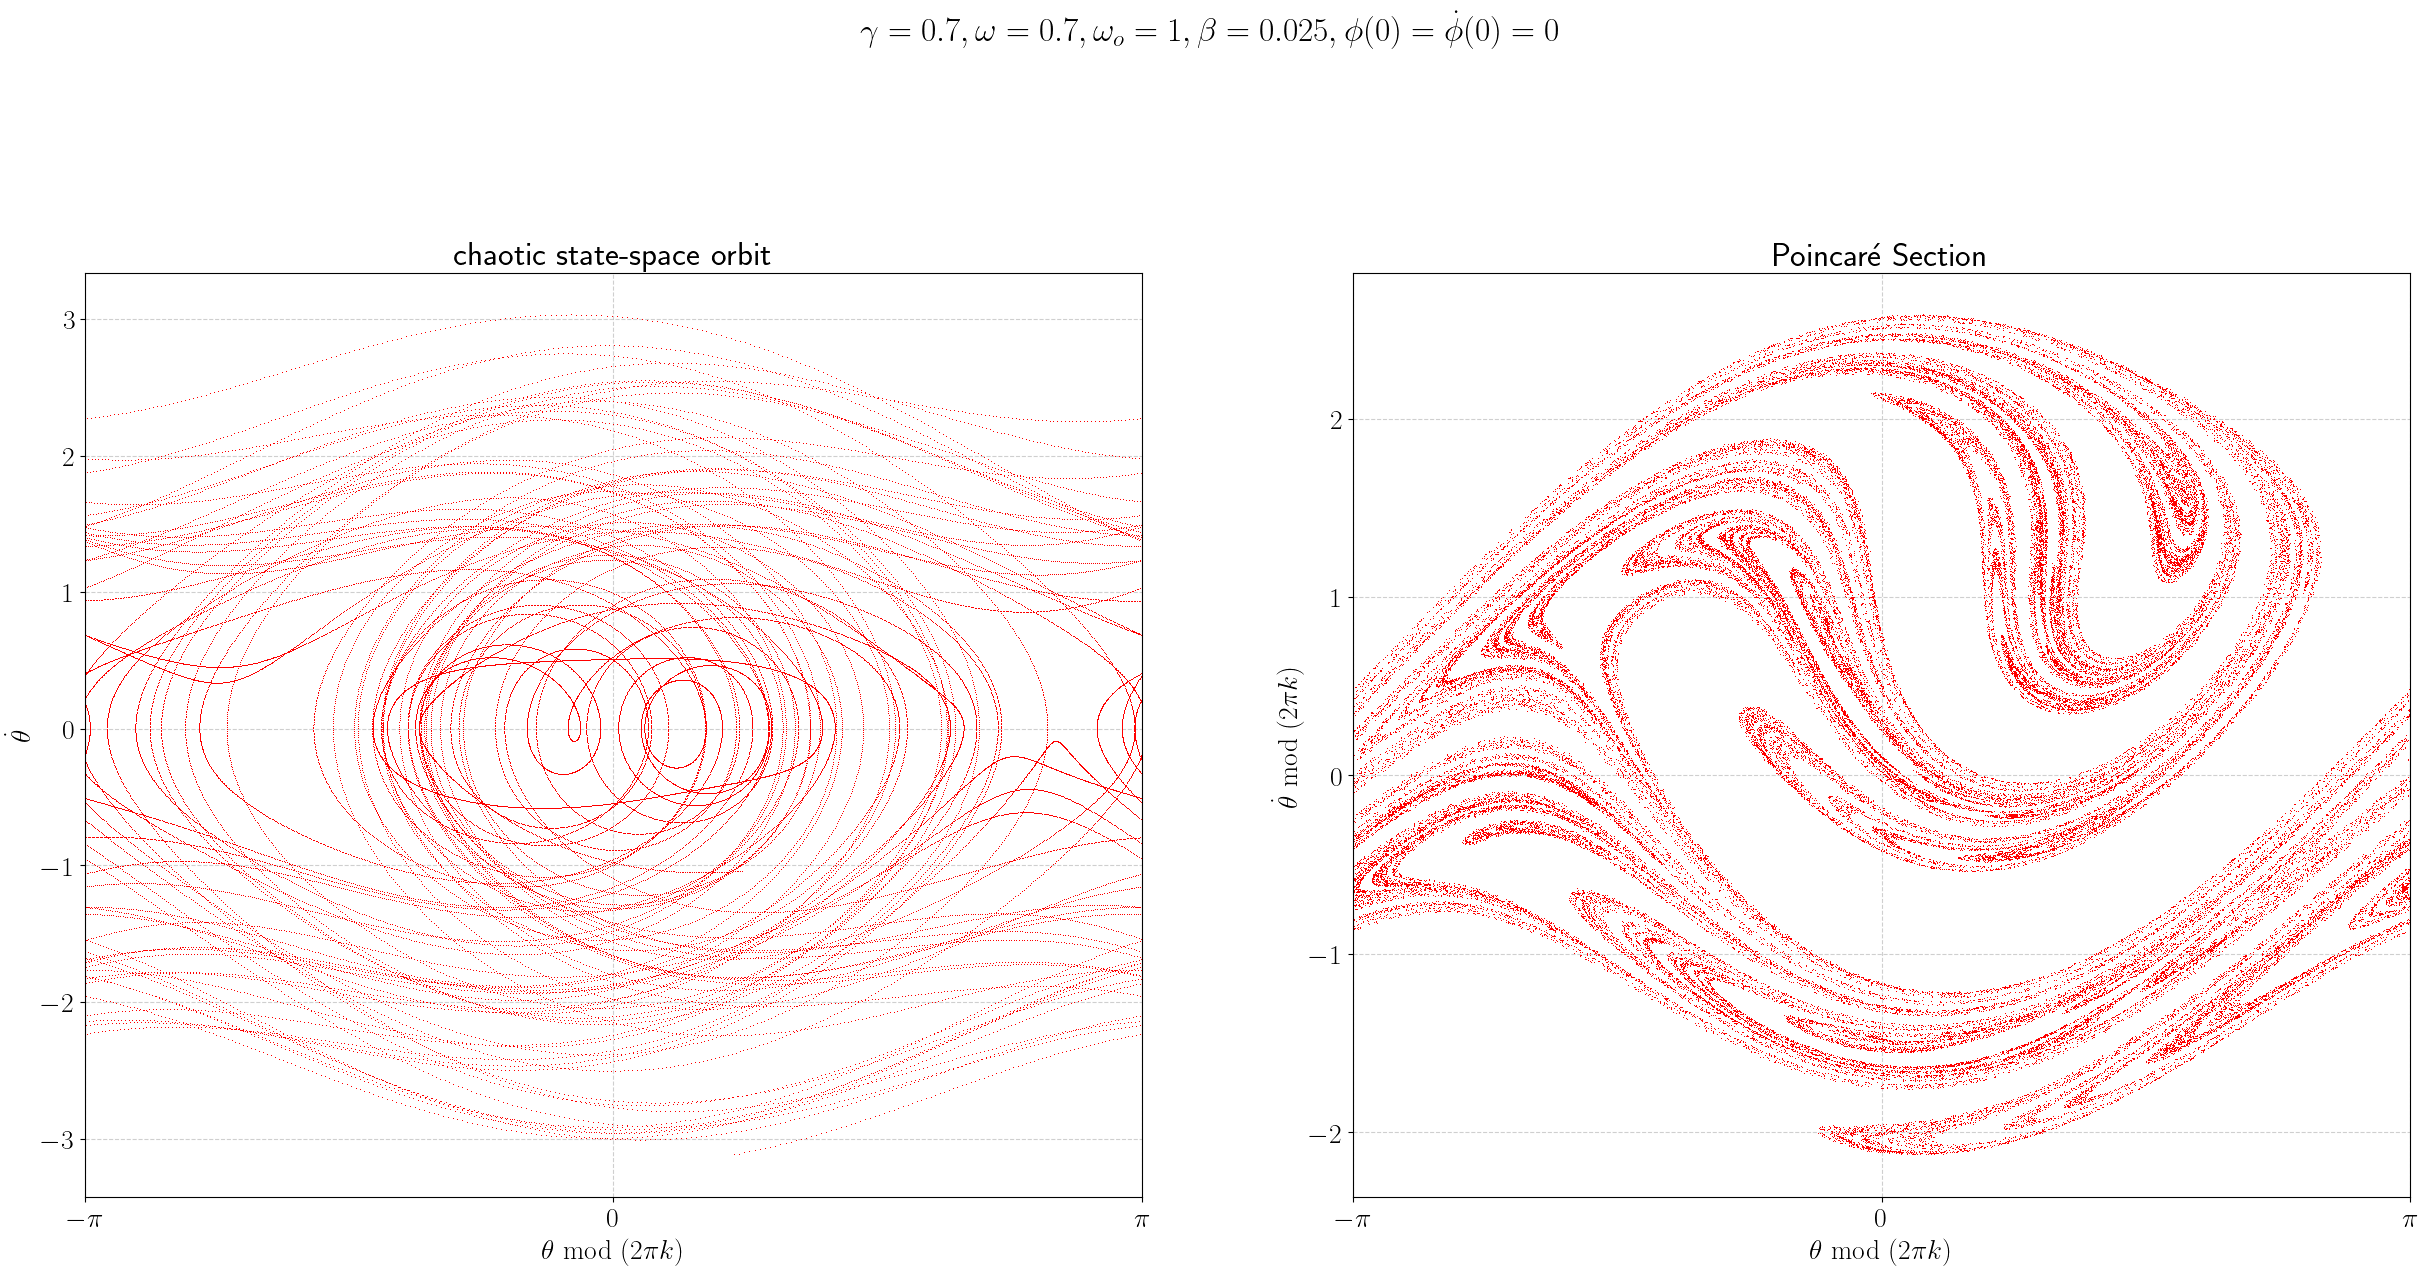

In [25]:
omega   = 0.7                             # Frequency of the driving force
omega_o = 1                               # Natural frequency
beta    = 0.025                           # Damping coefficient
gamma   = 0.7                             # Amplitude of the driving force
x0      = [0, 0]                          # Initial conditions [theta0, theta_dot0]
dt      = 0.01                            # Time step
t_span  = [0, 800000]                     # Time span
params  = [beta, omega_o, gamma, omega]
Tau     = 2 * np.pi / omega
t, soln = RK4(damped_driven_pendulum, t_span, params, dt, x0)
theta, theta_dot   = soln[:, 0], soln[:, 1]
chaotic_x          = (theta - np.pi) % (2*np.pi) - np.pi
indices            = (t / Tau % 1 < dt / Tau)
strobing_theta     = theta[indices]
strobing_theta_dot = theta_dot[indices]
poincare_x         = (strobing_theta - np.pi) % (2 * np.pi) - np.pi

fig, ax = plt.subplots(1,2,figsize=(30,12))
fig.suptitle(r'$ \gamma = 0.7,\omega = 0.7 ,\omega_o = 1 ,\beta=0.025,\phi(0)=\dot{\phi}(0)=0 $',y=1.1)
ax[0].plot(chaotic_x[int(10/dt):int(500/dt)], theta_dot[int(10/dt):int(500/dt)], 'r,' )
ax[0].set_title(f'chaotic state-space orbit')
ax[0].set_xlabel(r'$ \theta \ \mathrm{ mod } \ (2\pi k) $')
ax[0].set_ylabel(r'$ \dot{\theta} $')
ax[0].set_xlim(chaotic_x.min(), chaotic_x.max())
ax[0].set_xticks([-np.pi, 0, np.pi],[r'$-\pi$', r'$0$', r'$\pi$'])
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].plot(poincare_x[int(10/dt):], strobing_theta_dot[int(10/dt):], 'r,', ms=0.6)
ax[1].set_xlim(poincare_x.min(), poincare_x.max())
ax[1].set_xticks([-np.pi, 0, np.pi],[r'$-\pi$', r'$0$', r'$\pi$'])
ax[1].set_title(f'Poincaré Section ')
ax[1].set_xlabel(r'$ \theta \ \mathrm{ mod } \ (2\pi k) $')
ax[1].set_ylabel(r'$ \dot{\theta} \ \mathrm{ mod } \ (2\pi k)$')
ax[1].grid(True, linestyle='--', alpha=0.6)
plt.show()

A damped, driven pendulum can be described by the equation of motion (see, for
example [39]):

$ \qquad \displaystyle\ddot{\theta}=-\frac{g}{L}\sin\theta-\alpha\dot{\theta}+\beta\cos\left(\omega t\right)$

where we start with (6.17) and add a damping term $\thicksim-\dot{\theta}$ and time-dependent forcing
function by hand with constants $\alpha$ and $\beta$ setting the strength of these terms. If we set
$t = \sqrt{L/g}s$ for dimensionless $s$, then

$ \qquad \displaystyle\frac{d^2\theta}{ds^2}=-\sin\theta-\underbrace{\alpha\sqrt{\frac{L}{g}}}_{\equiv\text{ A}}\dot{\theta}+\underbrace{\beta\frac{L}{g}}_{\equiv\text{ B}}\cos\left(\omega \sqrt{\frac{L}{g}}s \right)$

and define the dimensionless driving frequency  $\Omega \equiv \omega\sqrt{\frac{L}{g}}$                                                                                   
(a) For $A = 1/(0.5), B = 1.5$ and $\Omega = 2/3,$ take $\Delta t = \frac{\Omega}{64},$ and run your RK4 ODE solver for $2^{16}$ steps starting from $\theta(0) = \frac{\pi}{2}$ and $\dot{\theta} = 0$.                                                            
Taking just the second half of the numerical solution (to allow transients to decay), plot the angle $\theta$ as a function of dimensionless time $s$.                                                                                                 
Compute the power spectrum and plot the log of the power spectrum, focusing on the area around the driving frequency $\Omega$.                                                                                                                            
(b) Re-do part (a) with $A = 1/3$, in the chaotic region for this problem

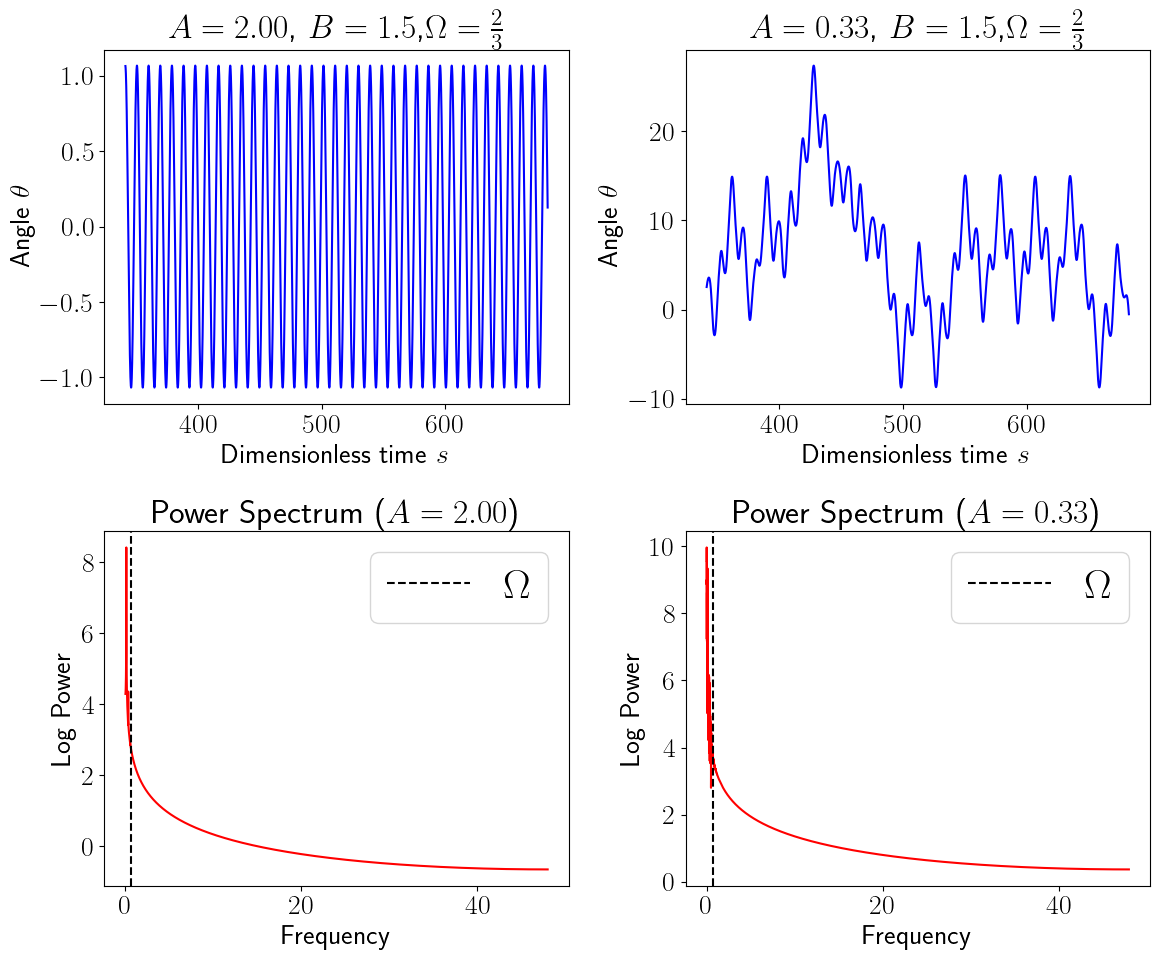

In [45]:
from scipy.fftpack import fft, fftfreq

def damped_driven_pendulum(s, state, params):
    theta, omega = state  # state = [theta, omega]
    A, B, Omega = params
    dtheta_ds = omega
    domega_ds = -np.sin(theta) - A * omega + B * np.cos(Omega * s)
    return np.array([dtheta_ds, domega_ds])

A_values = [1/0.5, 1/3]  # Two cases: non-chaotic and chaotic
B = 1.5
Omega = 2/3
dt = Omega / 64
num_steps = 2**16
s_span = (0, num_steps * dt)  # Time range
s_half = num_steps // 2       # Index for second half
theta0 = np.pi / 2
omega0 = 0
x0 = np.array([theta0, omega0])

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, A in enumerate(A_values):
    s_values, sol = RK4(damped_driven_pendulum, s_span, (A, B, Omega), dt, x0)
    s_values = s_values[s_half:]
    theta_values = sol[s_half:, 0]

    axes[i].plot(s_values, theta_values, color='b')
    axes[i].set_xlabel(r"Dimensionless time $s$")
    axes[i].set_ylabel(r"Angle $\theta$")
    axes[i].set_title(f"$A={A:.2f}$, $B={B}$,"+r"$\Omega=\frac{2}{3}$")
    
    # Compute power spectrum
    theta_fft = fft(theta_values - np.mean(theta_values))
    power_spectrum = np.abs(theta_fft)**2
    freq = fftfreq(len(theta_values), d=dt)  # Frequency axis

    mask = freq > 0  # Ignore negative frequencies
    axes[i+2].plot(freq[mask], np.log10(power_spectrum[mask]), color='r')
    axes[i+2].axvline(Omega, color='k', linestyle='--', label=r"$\Omega$")
    axes[i+2].set_xlabel("Frequency")
    axes[i+2].set_ylabel("Log Power")
    axes[i+2].set_title(f"Power Spectrum ($A={A:.2f}$)")
    axes[i+2].legend()

plt.tight_layout()
plt.show()